#### Intial Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

c:\Users\david\anaconda3\envs\Dsci\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
np.set_printoptions(suppress=True)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 45)

#### Loading & Checking Data

In [3]:
ptax_frame = pd.read_excel('data/ON_Ptax/VIEWFIR2021-22.xlsx', skiprows=4)

In [4]:
ptax_frame.shape

(7888, 29)

In [5]:
ptax_frame.head(2)

,Unnamed: 0,Year,Asmt Code,Municipality,MAH Code,MunID,UT,Tier,MSO,Line,Levy Area,22 Levy Area Name,RTC/RTQ,Tax\nBand,Property Class,Tax Rate Description,Tax Ratio,% Full Rate,CVA Assessment,Phase-In Taxable Assessment,LT/ST\nTax Rate,UT\nTax Rate,EDUC\nTax Rate,TOTAL\nTax Rate,LT/ST\nTaxes,UT\nTaxes,EDUC\nTaxes,TOTAL\nTaxes,Last Update
0,10_LT,2021,1134,Addington Highlands Tp,57611,11033,57,LT,12,10,0,Addington Highlands Tp,RT,0,Residential,Full Occupied,1.0,1.0,494713900.0,494713900.0,0.006078,0.004973,0.00153,0.012582,3007109,2460281,756912,6224302,2022-08-29
1,50_LT,2021,1134,Addington Highlands Tp,57611,11033,57,LT,12,50,0,Addington Highlands Tp,MT,0,Multi-Residential,Full Occupied,2.0,1.0,1377000.0,1377000.0,0.012157,0.009946,0.00153,0.023633,16740,13696,2107,32543,2022-08-29


This is a bit strange - for some reason Pickering was not included in the data for 2021.

In [6]:
ptax_frame[ptax_frame['Municipality'] == 'Pickering C']

,Unnamed: 0,Year,Asmt Code,Municipality,MAH Code,MunID,UT,Tier,MSO,Line,Levy Area,22 Levy Area Name,RTC/RTQ,Tax\nBand,Property Class,Tax Rate Description,Tax Ratio,% Full Rate,CVA Assessment,Phase-In Taxable Assessment,LT/ST\nTax Rate,UT\nTax Rate,EDUC\nTax Rate,TOTAL\nTax Rate,LT/ST\nTaxes,UT\nTaxes,EDUC\nTaxes,TOTAL\nTaxes,Last Update


Overall it seems that everything looks fine.  We will drop the "Unnamed: 0" column along with a few other columns (mainly different identifiers).

In [7]:
ptax_frame.drop(columns=['Unnamed: 0', 'Asmt Code', 'MAH Code', 'MunID', 'UT', 'MSO', 'Line', 'Levy Area', '% Full Rate', 'Last Update'], inplace=True)

Next we will rename the columns.  Most were fairly understandable, but they had some extraneous characters (e.g.\n). Also I wanted to eliminate the spaces in some column names as these can create trouble for certain pandas syntax(e.g. ptax_frame.Total_TaxRate)

In [8]:
ptax_frame.rename(columns={'22 Levy Area Name':'Levy_Area', 'CVA Assessment':'CVA_Assessment', 'Phase-In Taxable Assessment':'Phase_In_Taxable_Assessment', 'Tax Ratio':'Tax_Ratio', 'Property Class':'Property_Class', 'Tax Rate Description':'Tax_Rate_Description', '% Full Ratio': 'percent_Full_Ratio','Tax\nBand':'TaxBand','LT/ST\nTax Rate':'LowerSingleTier_Rate', 'UT\nTax Rate':'UpperTier_Rate', 'EDUC\nTax Rate':'Education_Rate', 'TOTAL\nTax Rate':'Total_TaxRate', 'LT/ST\nTaxes':'LowerSingleTierTaxes', 'UT\nTaxes':'UpperTierTaxes', 'EDUC\nTaxes':'EducationTaxes', 'TOTAL\nTaxes':'TotalTax'}, inplace=True)

In [9]:
ptax_frame.head(1)

,Year,Municipality,Tier,Levy_Area,RTC/RTQ,TaxBand,Property_Class,Tax_Rate_Description,Tax_Ratio,CVA_Assessment,Phase_In_Taxable_Assessment,LowerSingleTier_Rate,UpperTier_Rate,Education_Rate,Total_TaxRate,LowerSingleTierTaxes,UpperTierTaxes,EducationTaxes,TotalTax
0,2021,Addington Highlands Tp,LT,Addington Highlands Tp,RT,0,Residential,Full Occupied,1.0,494713900.0,494713900.0,0.006078,0.004973,0.00153,0.012582,3007109,2460281,756912,6224302


### Selecting GTA Data

For this particular project, we are comparing property tax rates for the Greater Toronto Area.  Consequently, I set up lists of the various GTA municipalities by region/county.  Then I put together a GTA data frame using these identifiers.

In [10]:
Durham = ['Durham R','Ajax T', 'Clarington M', 'Brock Tp', 'Oshawa C', 'Pickering C', 'Scugog Tp', 'Uxbridge Tp', 'Whitby T']
Halton = ['Halton R', 'Burlington C', 'Halton Hills T', 'Milton T', 'Oakville T']
Peel = ['Peel R', 'Brampton C', 'Mississauga C', 'Caledon T']
York = ['York R', 'Vaughan C', 'Markham C', 'Richmond Hill C', 'Aurora T', 'Newmarket T', 'Whitchurch - Stouffville T', 'East Gwillimbury T', 'Georgina T', 'King Tp']
Dufferin = ['Mono T', 'Orangeville T']
Simcoe = ['Bradford West Gwillimbury T', 'New Tecumseth T']
Toronto = ['Toronto C']

In [11]:
GTA = Durham + Halton + Peel + York + Dufferin + Simcoe + Toronto

In [12]:
len(GTA)

33

In [13]:
gta_ptax_frame = ptax_frame[ptax_frame['Municipality'].isin(GTA)]

In [14]:
gta_ptax_frame.shape

(1025, 19)

Ontario's system of property tax is highly complex with a large number of different property tax classes and subclasses.  As we can see below, this results in a large number of records that would overcomplicate our basic comparison.  I decided on two different ways of simplifying the data we are going to be looking at.

In [15]:
gta_ptax_frame['Property_Class'].value_counts()

Industrial                 190
Commercial                 177
Commercial, NConstr.        79
Residential                 69
Shopp. Centre, NConstr.     58
Shopping Centre             58
Large Industrial            58
Industrial, NConstr.        53
Office Building             51
Multi-Residential           36
Pipeline                    33
Farmland                    33
Parking Lot                 31
Office Build., NConstr.     31
Managed Forest              29
Large Ind., NConstr.        26
New Multi-Residential       11
Large Theatre                1
Prof. Sports Facility        1
Name: Property_Class, dtype: int64

1. I select the 7 mandatory property classes

In [16]:
pclasses = ['Residential', 'Commercial', 'Industrial', 'Multi-Residential', 'Farmland', 'Managed Forest', 'Pipeline']

2. I selected only the 'Full Occupied' class for each of these 7 classes

In [17]:
gta_ptax_frame = gta_ptax_frame[(gta_ptax_frame['Property_Class'].isin(pclasses)) & (gta_ptax_frame['Tax_Rate_Description'] == 'Full Occupied')].copy()

In [18]:
gta_ptax_frame.head()

,Year,Municipality,Tier,Levy_Area,RTC/RTQ,TaxBand,Property_Class,Tax_Rate_Description,Tax_Ratio,CVA_Assessment,Phase_In_Taxable_Assessment,LowerSingleTier_Rate,UpperTier_Rate,Education_Rate,Total_TaxRate,LowerSingleTierTaxes,UpperTierTaxes,EducationTaxes,TotalTax
55,2021,Ajax T,LT,Ajax T,RT,0,Residential,Full Occupied,1.0000,1.773831e+10,1.773831e+10,0.003414,0.005013,0.001530,0.009957,60558780,88919151,27139620,176617551
56,2021,Ajax T,LT,Ajax T,MT,0,Multi-Residential,Full Occupied,1.8665,5.028436e+08,5.028436e+08,0.006372,0.009356,0.001530,0.017259,3204245,4704831,769351,8678427
57,2021,Ajax T,LT,Ajax T,FT,0,Farmland,Full Occupied,0.2000,2.776680e+07,2.776680e+07,0.000683,0.001003,0.000382,0.002068,18959,27838,10621,57418
58,2021,Ajax T,LT,Ajax T,CT,0,Commercial,Full Occupied,1.4500,9.720312e+08,9.720312e+08,0.004950,0.007269,0.008800,0.021019,4811856,7065306,8553874,20431036
66,2021,Ajax T,LT,Ajax T,IT,0,Industrial,Full Occupied,2.0235,1.330657e+08,1.330657e+08,0.006908,0.010143,0.008800,0.025852,919251,1349747,1170978,3439976


Next I decided on separating the upper tier from the lower and sigle tier municipalities.  However, I then added a new column to identify the region to which the lower tier municipalities belong (the only single tier municipality is the city of Toronto which I simply set to itself).

In the visualizations for the lower tier municipalities, I will then use color to identify each municipalities region thereby allowing a comparison of the regional rates indirectly.  Later I go on to look at the regional rates in isolation.

In [19]:
upper_tier = ['York R', 'Halton R', 'Peel R', 'Durham R']

In [20]:
gta_sL_ptax= gta_ptax_frame[~gta_ptax_frame.Municipality.isin(upper_tier)]
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Durham),['Region']] = 'Durham R'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(York),['Region']] = 'York R'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Peel),['Region']] = 'Peel R'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Halton),['Region']] = 'Halton R'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Dufferin),['Region']] = 'Dufferin Co'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Simcoe),['Region']] = 'Simcoe Co'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Toronto),['Region']] = 'Toronto C'

In [21]:
gta_ut_ptax = gta_ptax_frame[gta_ptax_frame.Municipality.isin(upper_tier)]


Now that we have finally selected the data, I will check for missing (Na) values.  We can see below that there are only 9 Na values for the single and lower tier data - all of which are for UpperTier_Rate.  These values are for Toronto data because Toronto is a single tier municipality so there is no problem here.

There are a greater number of Na values for the upper tier but this is just because all upper tier municipalities do not have lower tier or education tax rates.

In [22]:
gta_sL_ptax.isna().sum()

Year                           0
Municipality                   0
Tier                           0
Levy_Area                      0
RTC/RTQ                        0
TaxBand                        0
Property_Class                 0
Tax_Rate_Description           0
Tax_Ratio                      0
CVA_Assessment                 0
Phase_In_Taxable_Assessment    0
LowerSingleTier_Rate           0
UpperTier_Rate                 8
Education_Rate                 0
Total_TaxRate                  0
LowerSingleTierTaxes           0
UpperTierTaxes                 0
EducationTaxes                 0
TotalTax                       0
Region                         0
dtype: int64

In [23]:
gta_ut_ptax.isna().sum()

Year                            0
Municipality                    0
Tier                            0
Levy_Area                       0
RTC/RTQ                         0
TaxBand                         0
Property_Class                  0
Tax_Rate_Description            0
Tax_Ratio                       0
CVA_Assessment                  0
Phase_In_Taxable_Assessment     0
LowerSingleTier_Rate           42
UpperTier_Rate                  0
Education_Rate                 42
Total_TaxRate                   0
LowerSingleTierTaxes            0
UpperTierTaxes                  0
EducationTaxes                  0
TotalTax                        0
dtype: int64

The last thing that needs to be done to prep the data is to set up a palette so that the colors of the various regions are consistent between various visualizations.

In [24]:
palette = {
    'Toronto C': 'dodgerblue',
    'York R': 'firebrick',
    'Halton R': 'limegreen',
    'Peel R':'indigo',
    'Durham R': 'gold',
    'Simcoe Co': 'turquoise',
    'Dufferin Co':'violet'
}

## Visualizations

### Comparing Lower Single Tier Rates for 7 Main Property Classes

We start by looking at residential property tax rates.  This is a natural starting point because in Ontario's system the residential class provides the base rate with other classes the rates of which are expressed as ratios of this residential rate.

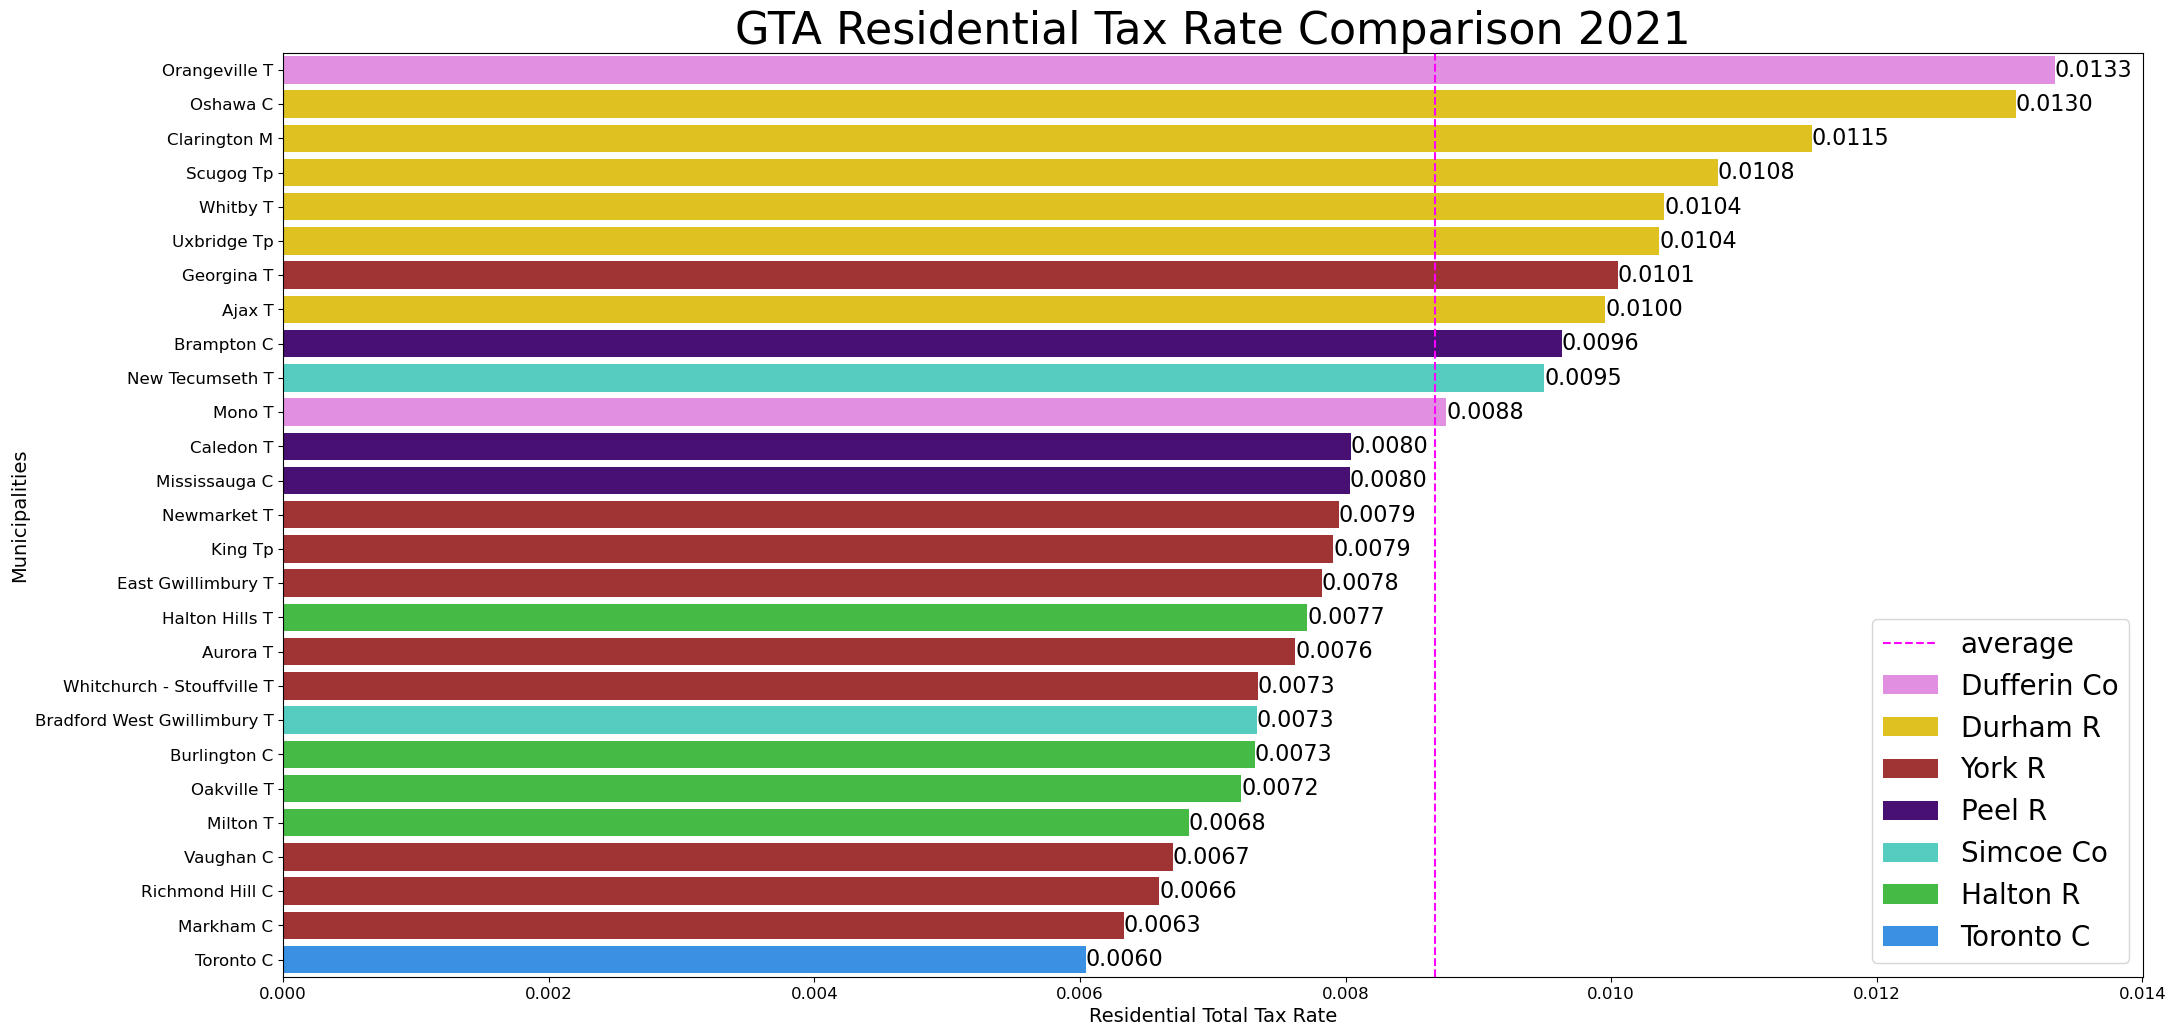

In [25]:
data=gta_sL_ptax[gta_sL_ptax['Property_Class'] == 'Residential'].sort_values(by='Total_TaxRate', ascending=False)

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data, y='Municipality', x='Total_TaxRate', orient='h', palette=palette, dodge=False, hue='Region')
ax.set_xlabel('Residential Total Tax Rate', fontsize=14)
ax.set_ylabel('Municipalities', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_title('GTA Residential Tax Rate Comparison 2021', fontsize=32)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', fontsize=16)
plt.axvline(data['Total_TaxRate'].mean(), color='magenta', linestyle='dashed', label='average')
plt.legend(loc='lower right', prop={'size':20})
plt.show()

There are a few things here that of note:
1. it is very noticeable that Toronto rate is not only the lowest but also significantly lower than the average rate across the GTA.  
1. with the exception of Oshawa and Brampton, all of the cities in the GTA have property tax rates below the average.
1. The regions are fairly mixed except for Durham Region which tends to have higher than average tax rates.

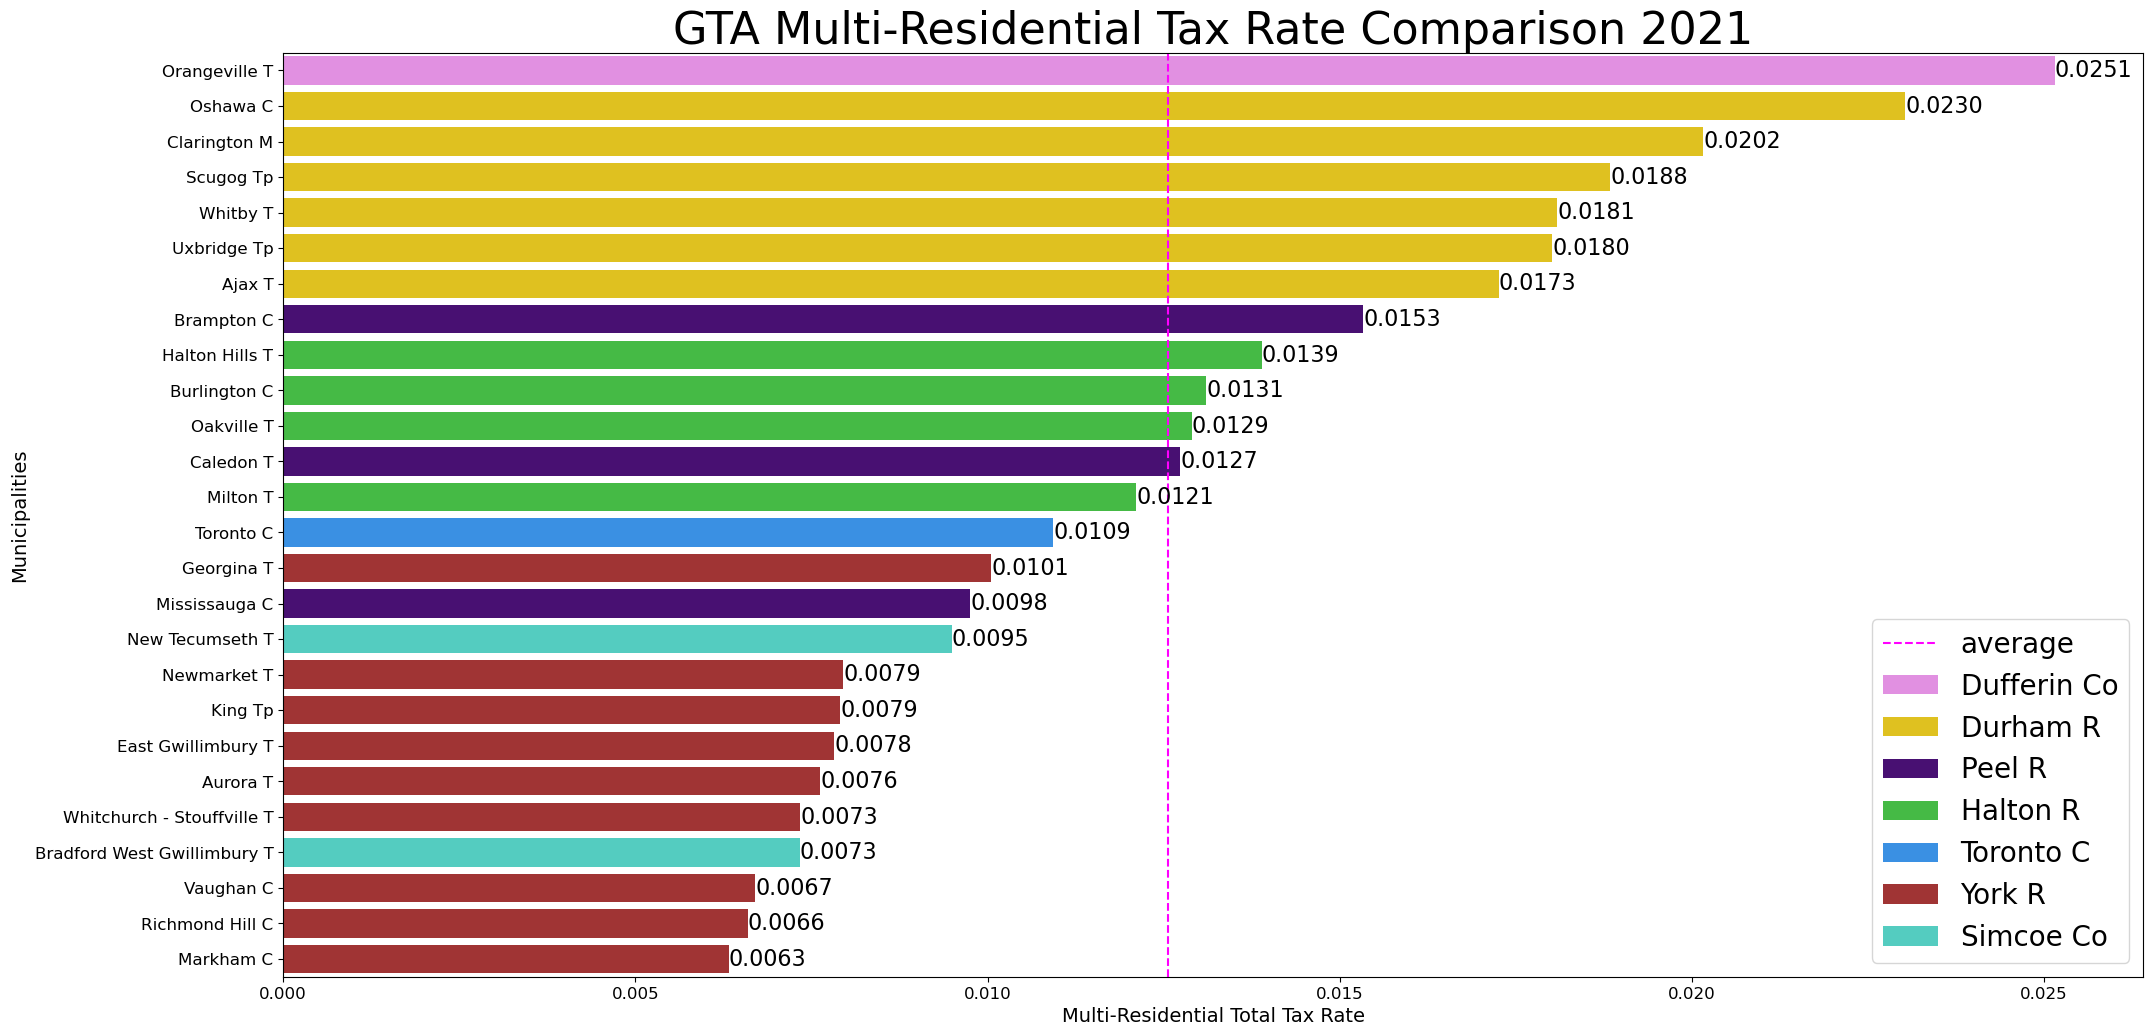

In [26]:
data=gta_sL_ptax[gta_sL_ptax['Property_Class'] == 'Multi-Residential'].sort_values(by='Total_TaxRate', ascending=False)

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data, y='Municipality', x='Total_TaxRate', orient='h', palette=palette, dodge=False, hue='Region')
ax.set_xlabel('Multi-Residential Total Tax Rate', fontsize=14)
ax.set_ylabel('Municipalities', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_title('GTA Multi-Residential Tax Rate Comparison 2021', fontsize=32)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', fontsize=16)
plt.axvline(data['Total_TaxRate'].mean(), color='magenta', linestyle='dashed', label='average')
plt.legend(loc='lower right', prop={'size':20})
plt.show()

Looking at the Multiresidential rate we can see that the average rate for the GTA is quite a bit higher at aproximately 0.013 vs 0.009 for Residential.  This reflects the fact that renters generally pay (via their landlord) higher rates than that those of single residences.

It is particularly noticeable that Toronto shoots up toward the middle of the pack after being the lowest for residential rates.

It is also noteworthy that the municipalities of York Region represent a real exception as their Multiresidential rates are equal to their Residential rates (also true of the two small communities that are in Dufferin County).

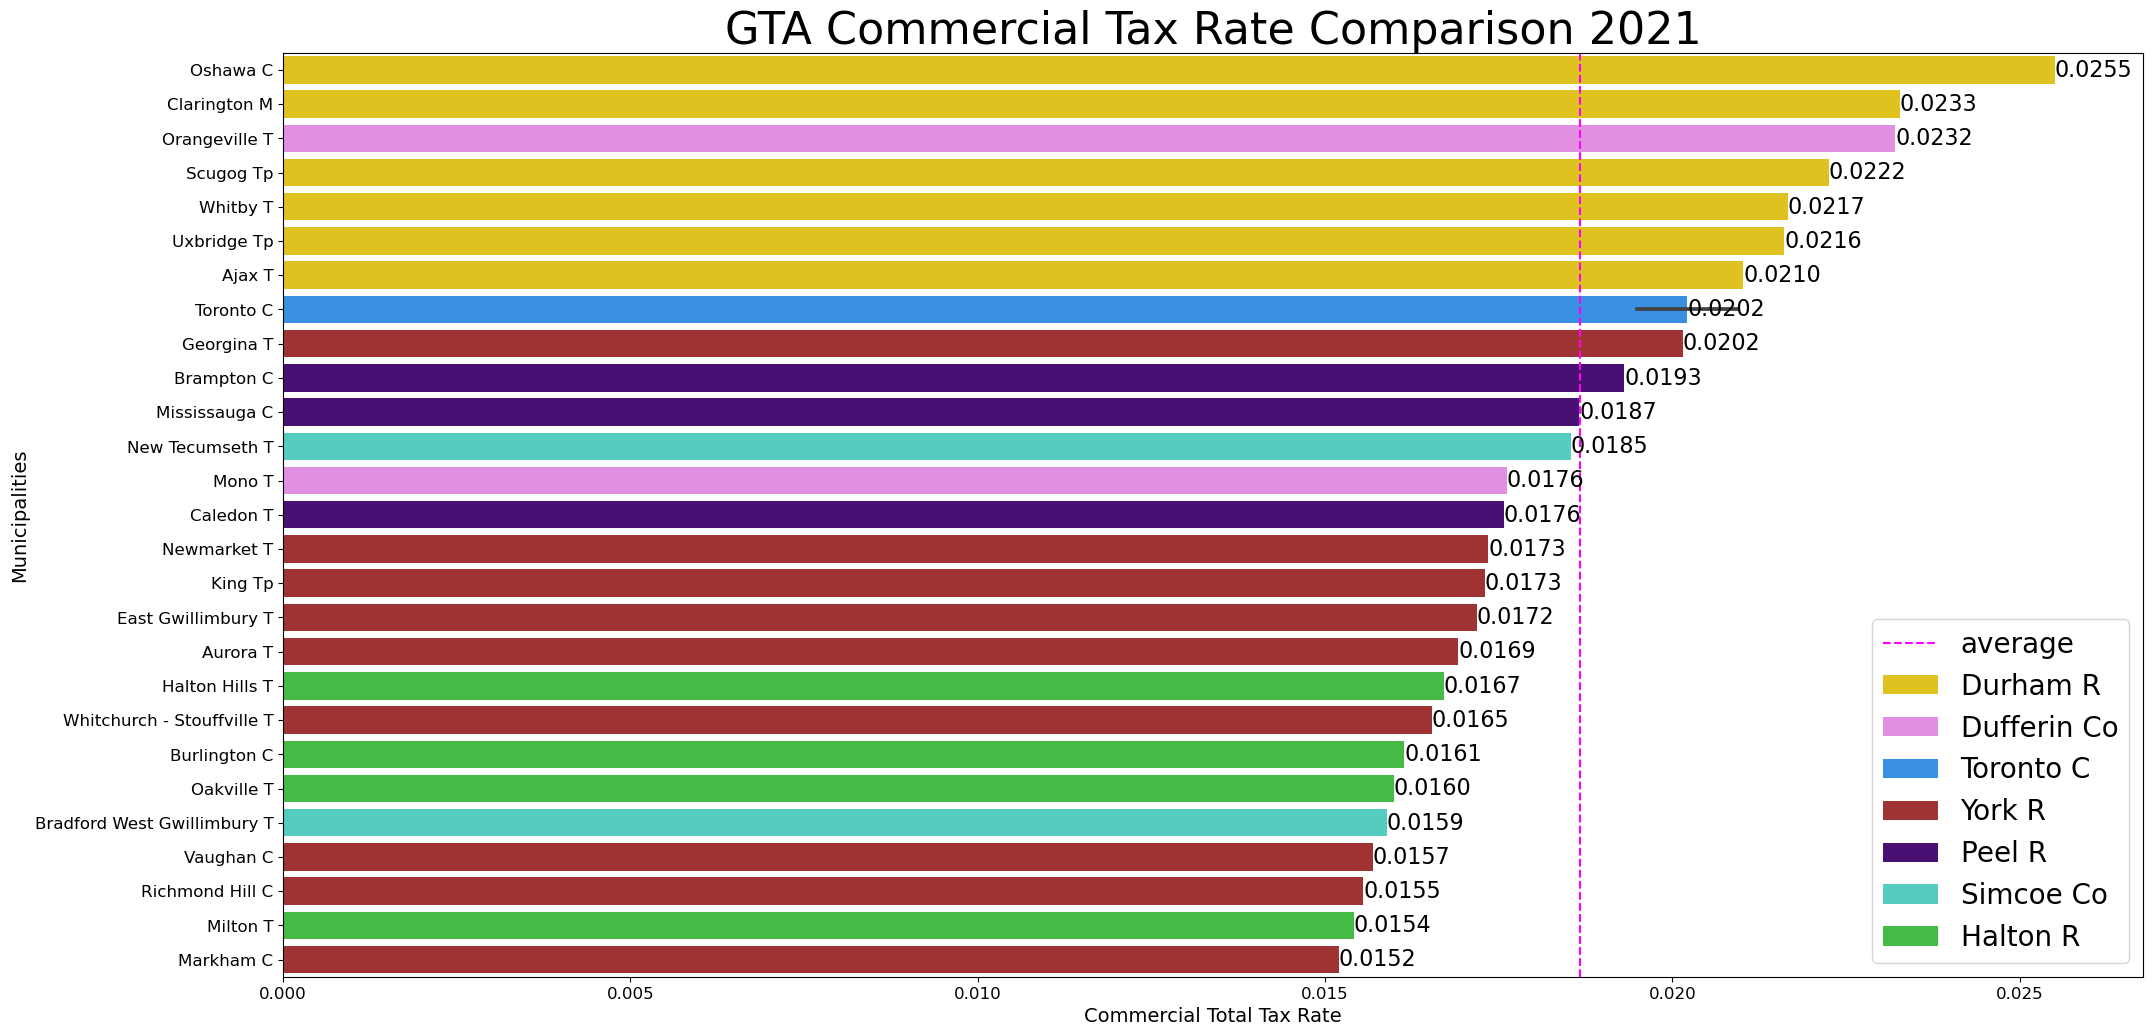

In [27]:
data=gta_sL_ptax[gta_sL_ptax['Property_Class'] == 'Commercial'].sort_values(by='Total_TaxRate', ascending=False)

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data, y='Municipality', x='Total_TaxRate', orient='h', palette=palette, dodge=False, hue='Region')
ax.set_xlabel('Commercial Total Tax Rate', fontsize=14)
ax.set_ylabel('Municipalities', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_title('GTA Commercial Tax Rate Comparison 2021', fontsize=32)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', fontsize=16)
plt.axvline(data['Total_TaxRate'].mean(), color='magenta', linestyle='dashed', label='average')
plt.legend(loc='lower right', prop={'size':20})
plt.show()

Looking at Commercial rates, we can see that Commercial rates are higher than those for single residential properties usually being about twice the Residential rate.

Toronto also stands out again for a couple of reasons.

It has moved up after being the lowest in the Residential class to being amongst the highest in terms of the Commercial class.

There is a slight irregularity for Toronto in the chart above.  Notice the black error bar at the end of the bar representing Toronto's Commercial Rate.  This shows up because there are actually two commercial property class rates for Full Occupied properties in Toronto.

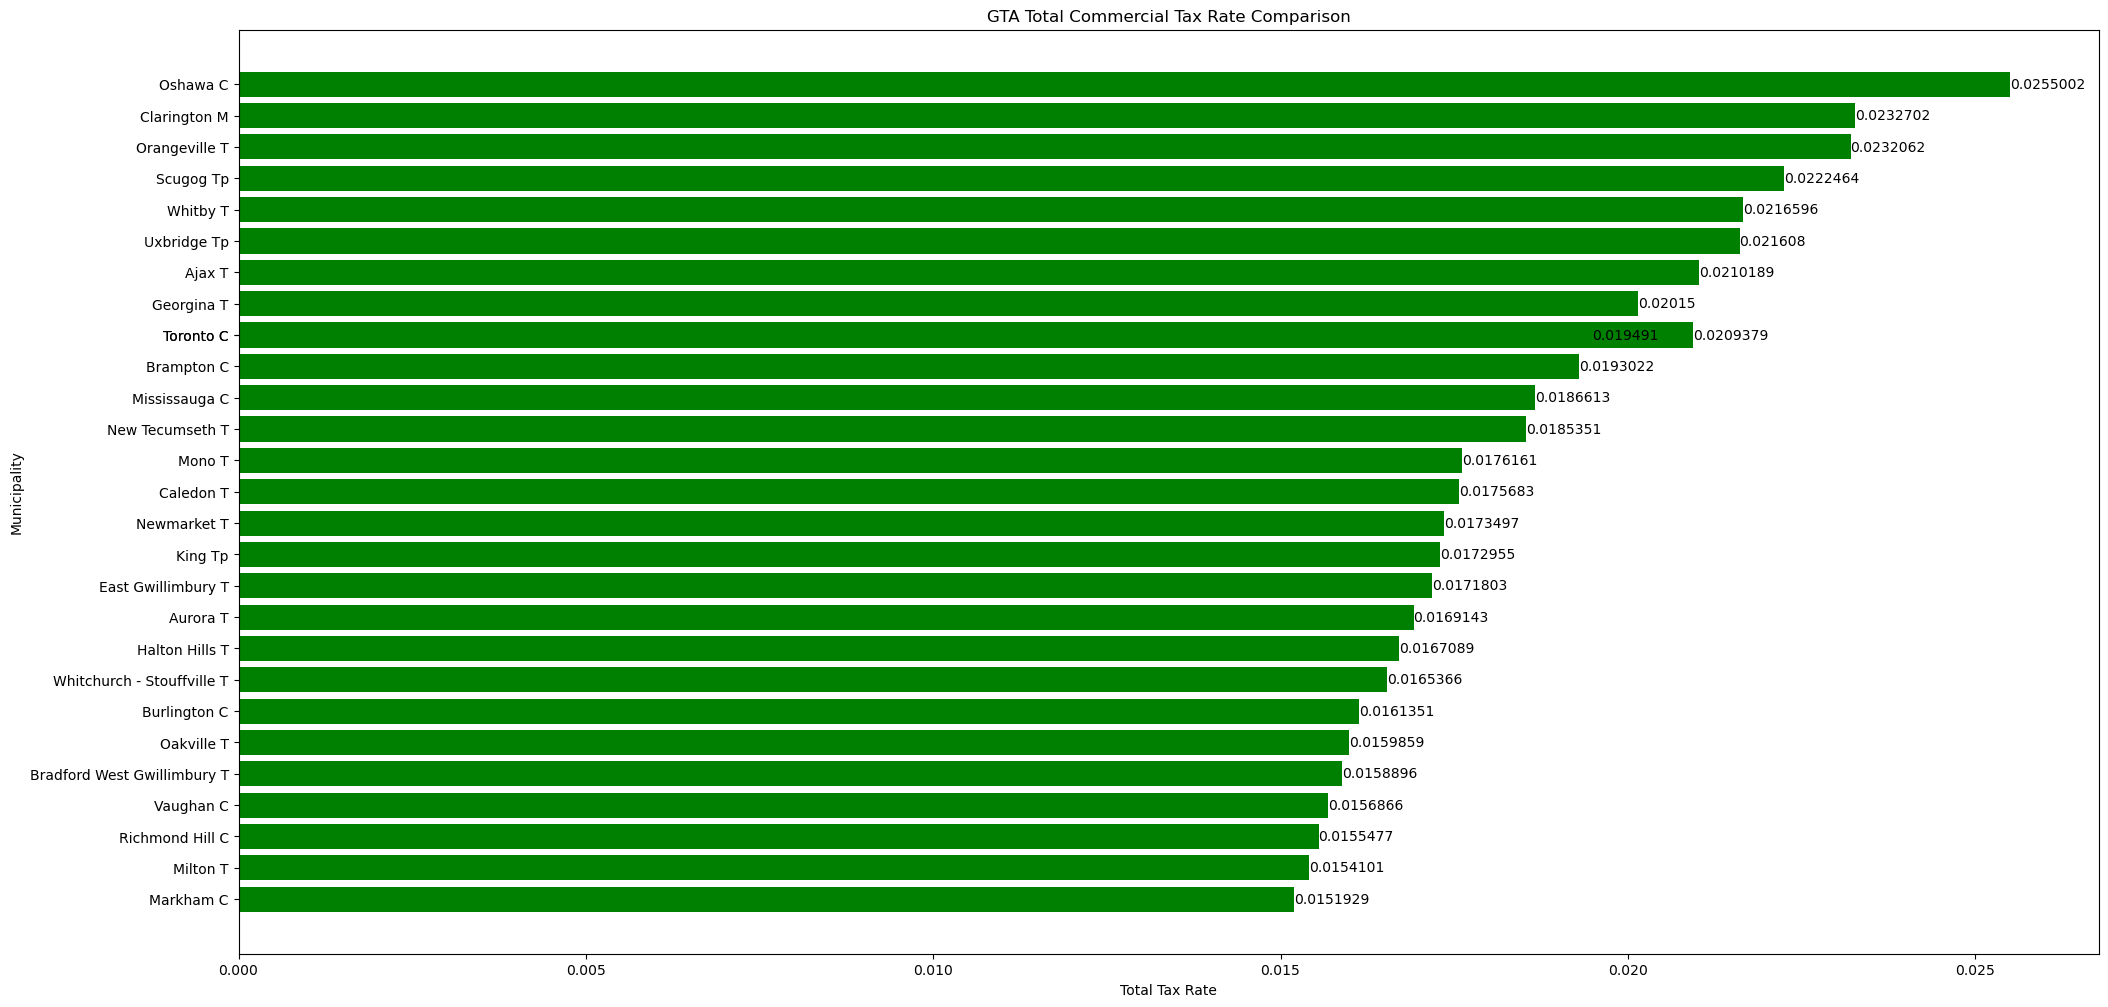

In [28]:
data = gta_sL_ptax[gta_sL_ptax['Property_Class'] == 'Commercial'].sort_values(by='Total_TaxRate')

fig,ax = plt.subplots(figsize=(24,12))
bars = ax.barh(data['Municipality'],data['Total_TaxRate'],align='center', color=['green'])
ax.set_yticks(data['Municipality'])
ax.set_xlabel('Total Tax Rate')
ax.set_ylabel('Municipality')
ax.set_title('GTA Total Commercial Tax Rate Comparison')
ax.bar_label(bars)
plt.show()

This chart clearly shows the two commercial tax rates for Toronto.

These two rates represent graduated taxation (banding).  With banding properties assessmented below a certain value threshold are taxed at a lower rate while all remaining properties are taxed at a higher level.  Banding represents redistribution within a revene class (i.e. revenue neutral). The higher tax on the upper band has to make up the revenue that is forgone by the lower rate on the lower band.  This then provides a degree of property tax relief for smaller businesses in Toronto.

Very few municipalities use this method of graduated taxation (e.g. Orillia and Smith's Falls)

In [29]:
gta_ptax_frame[(gta_ptax_frame['Property_Class'] == 'Commercial') & (gta_ptax_frame['Municipality'] == 'Toronto C')]

,Year,Municipality,Tier,Levy_Area,RTC/RTQ,TaxBand,Property_Class,Tax_Rate_Description,Tax_Ratio,CVA_Assessment,Phase_In_Taxable_Assessment,LowerSingleTier_Rate,UpperTier_Rate,Education_Rate,Total_TaxRate,LowerSingleTierTaxes,UpperTierTaxes,EducationTaxes,TotalTax
7064,2021,Toronto C,ST,Toronto C,CT,L,Commercial,Full Occupied,2.5743,2.035952e+10,2.035952e+10,0.011090,NaN,0.008401,0.019491,225784660,0,171042383,396827043
7065,2021,Toronto C,ST,Toronto C,CT,H,Commercial,Full Occupied,2.5743,3.496227e+10,3.496227e+10,0.011913,NaN,0.009025,0.020938,416510029,0,315526067,732036096


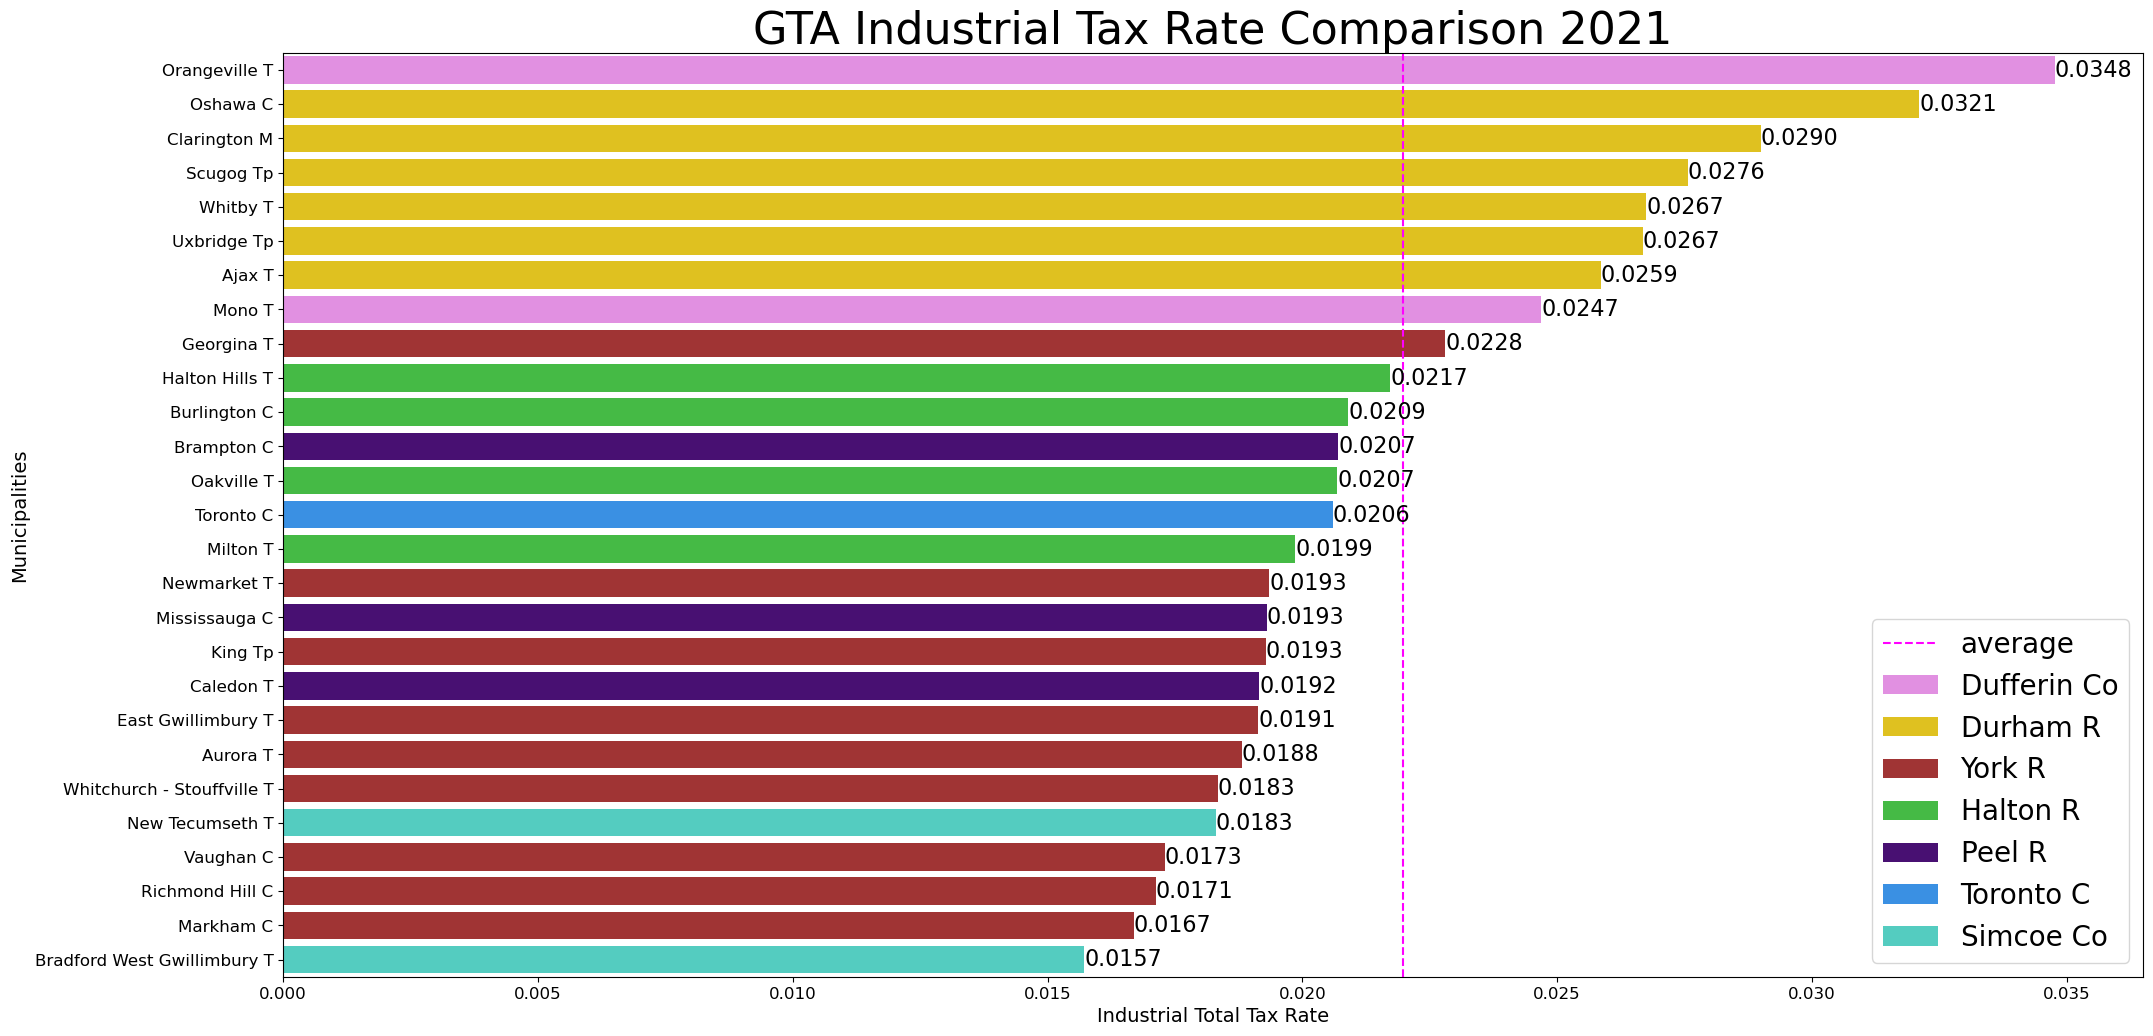

In [30]:
data=gta_sL_ptax[gta_sL_ptax['Property_Class'] == 'Industrial'].sort_values(by='Total_TaxRate', ascending=False)

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data, y='Municipality', x='Total_TaxRate', orient='h', palette=palette, dodge=False, hue='Region')
ax.set_xlabel('Industrial Total Tax Rate', fontsize=14)
ax.set_ylabel('Municipalities', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_title('GTA Industrial Tax Rate Comparison 2021', fontsize=32)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', fontsize=16)
plt.axvline(data['Total_TaxRate'].mean(), color='magenta', linestyle='dashed', label='average')
plt.legend(loc='lower right', prop={'size':20})
plt.show()

Industrial tax rates on the whole are a bit higher than Commercial rates.  While for the Commercial class the average was just below 0.02, for the Industrial class the rate has moved up to approximately 0.023.

Considering the charts thus far, we can see a bit of pattern with communities in Durham Region having the highest rates while York Region has tended to have the lowest rates.  The three members of Peel Region tend toward the middle.  As previously mentioned Toronto starts out very low in the Residential and then tends to move towards the middle but only its Commercial rates are above the GTA average.

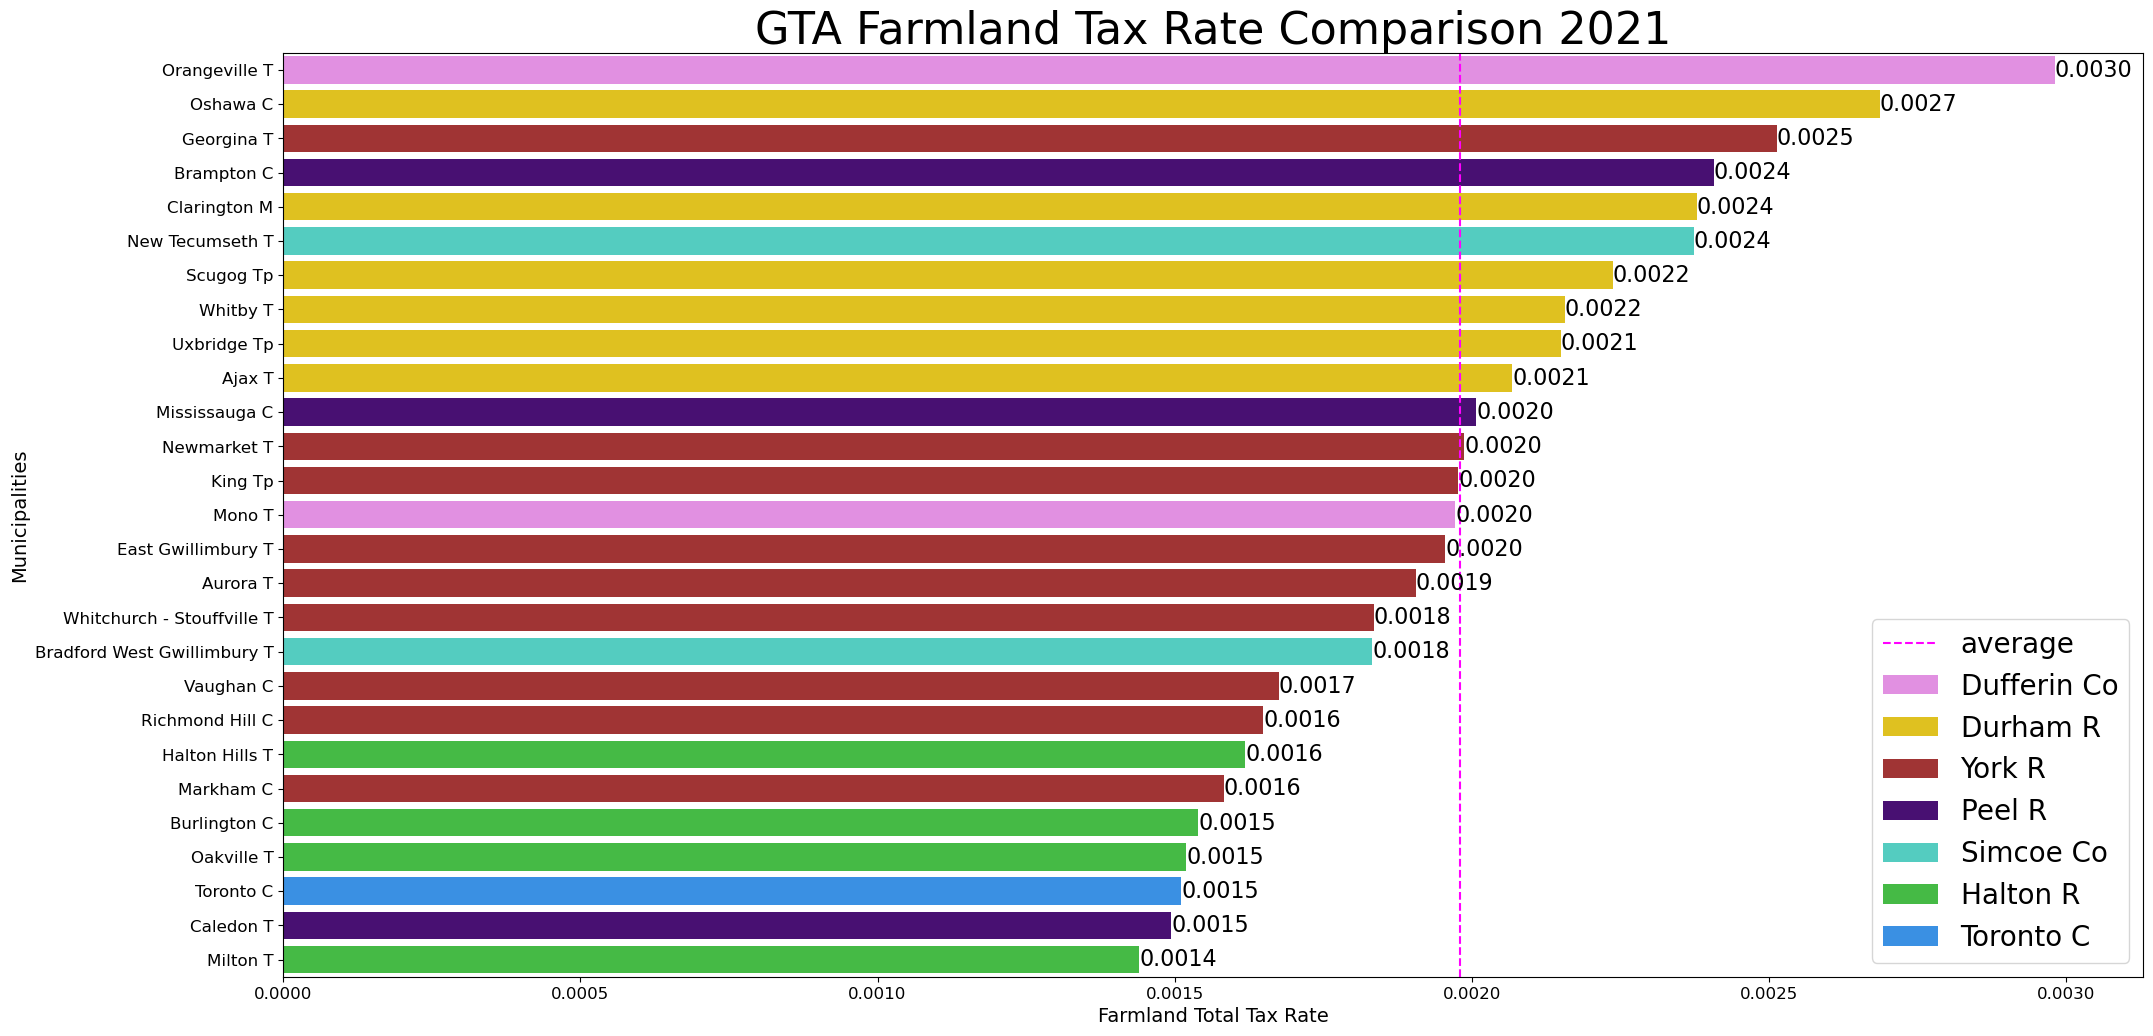

In [31]:
data=gta_sL_ptax[gta_sL_ptax['Property_Class'] == 'Farmland'].sort_values(by='Total_TaxRate', ascending=False)

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data, y='Municipality', x='Total_TaxRate', orient='h', palette=palette, dodge=False, hue='Region')
ax.set_xlabel('Farmland Total Tax Rate', fontsize=14)
ax.set_ylabel('Municipalities', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_title('GTA Farmland Tax Rate Comparison 2021', fontsize=32)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', fontsize=16)
plt.axvline(data['Total_TaxRate'].mean(), color='magenta', linestyle='dashed', label='average')
plt.legend(loc='lower right', prop={'size':20})
plt.show()

We finish looking by looking at the rates for Farmland.  These rates are much lower than the Residential rates let alone the Commercial or Industrial rates.  It is interesting that in this particular class York Region does not have the lowest rates.

### Regional Property Tax Comparison

We already saw some of the differences in tax rates across the upper tiers in the GTA via the color coding of the lower tier municipalities in the previous set of charts.

Now though we move on to directly compare property tax rates of the upper tiers.  Toronto itself drops out of these comparisons as it is a single tier municipality.

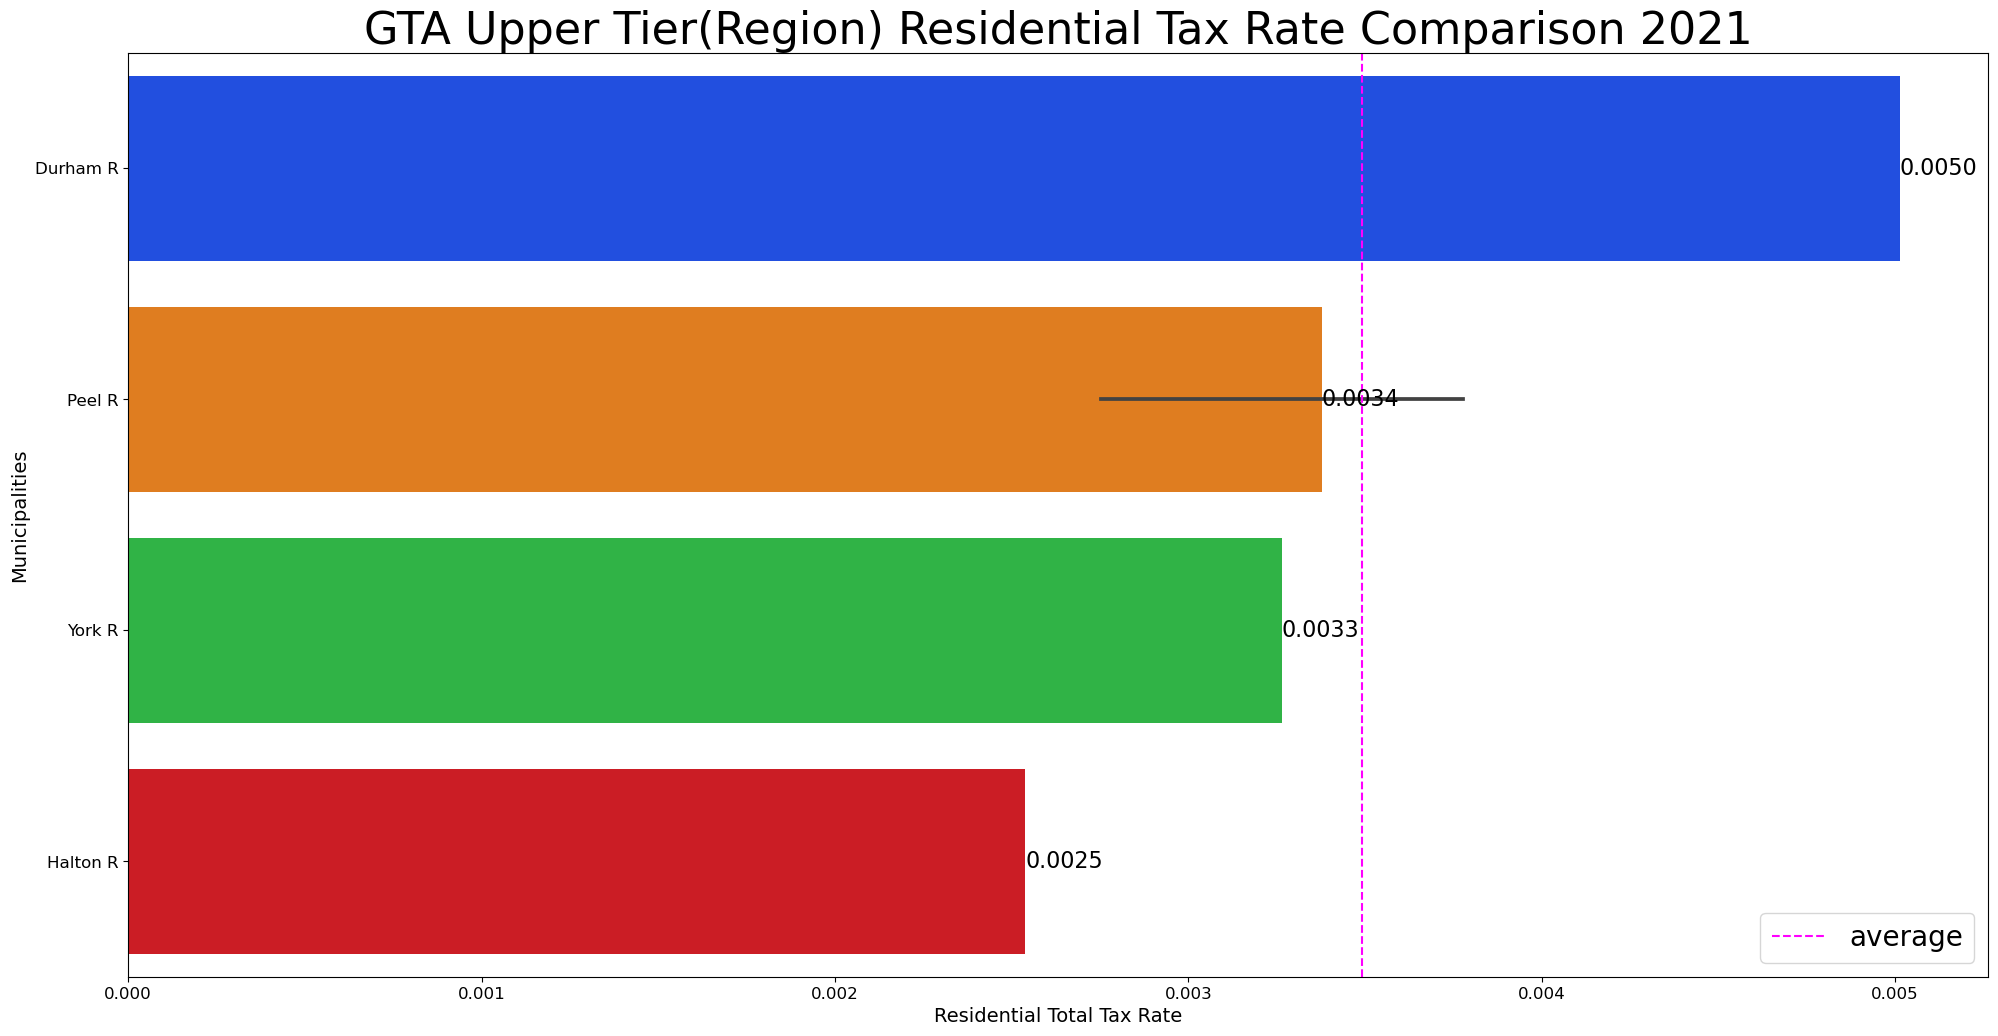

In [32]:
data=gta_ut_ptax[gta_ut_ptax['Property_Class'] == 'Residential'].sort_values(by='Total_TaxRate', ascending=False)

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data, y='Municipality', x='Total_TaxRate', orient='h', palette='bright', dodge=False)
ax.set_xlabel('Residential Total Tax Rate', fontsize=14)
ax.set_ylabel('Municipalities', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_title('GTA Upper Tier(Region) Residential Tax Rate Comparison 2021', fontsize=32)
ax.bar_label(ax.containers[0], fmt='%.4f', fontsize=16)
plt.axvline(data['Total_TaxRate'].mean(), color='magenta', linestyle='dashed', label='average')
plt.legend(loc='lower right', prop={'size':20})
plt.show()

There is something interesting here.  In the chart above an error bar is included on the Peel Region bar.   I guessed that this was because there was more than one value per year for Peel.  The results below show that my suspicions were correct.

This is because Peel Region's upper tier tax rate varies by municipality such that Mississauga, Brampton and Caledon all have their own specific upper tier rate.  In contrast, all of the other regions have one rate for all the lower tier municipalities within their boundary.

In fact, Peel is the only upper tier government in all of Ontario that utilizes the provision in the Municipal Act to delegate upper tier tax rates to local municipalities.  According to Peel's 2020 Property Tax Policy Handbook the apportionment general and special upper-tier rates are based on the total relative share of each municipality's total Current Value Assessment(CVA).

In [33]:
data

,Year,Municipality,Tier,Levy_Area,RTC/RTQ,TaxBand,Property_Class,Tax_Rate_Description,Tax_Ratio,CVA_Assessment,Phase_In_Taxable_Assessment,LowerSingleTier_Rate,UpperTier_Rate,Education_Rate,Total_TaxRate,LowerSingleTierTaxes,UpperTierTaxes,EducationTaxes,TotalTax
1530,2021,Durham R,UT,Durham R,RT,0,Residential,Full Occupied,1.0,9.923010e+10,9.923010e+10,NaN,0.005013,NaN,0.005013,0,497423598,0,497423598
5167,2021,Peel R,UT,Brampton part,RT,0,Residential,Full Occupied,1.0,8.739958e+10,8.739958e+10,NaN,0.003776,NaN,0.003776,0,330057531,0,330057531
5229,2021,Peel R,UT,Mississauga part,RT,0,Residential,Full Occupied,1.0,1.250220e+11,1.250220e+11,NaN,0.003606,NaN,0.003606,0,450839315,0,450839315
7828,2021,York R,UT,York R,RT,0,Residential,Full Occupied,1.0,3.072265e+11,3.072265e+11,NaN,0.003264,NaN,0.003264,0,1002864139,0,1002864139
5202,2021,Peel R,UT,Caledon part,RT,0,Residential,Full Occupied,1.0,1.589314e+10,1.589314e+10,NaN,0.002752,NaN,0.002752,0,43736326,0,43736326
2542,2021,Halton R,UT,Halton R,RT,0,Residential,Full Occupied,1.0,1.280309e+11,1.280309e+11,NaN,0.002539,NaN,0.002539,0,325038396,0,325038396


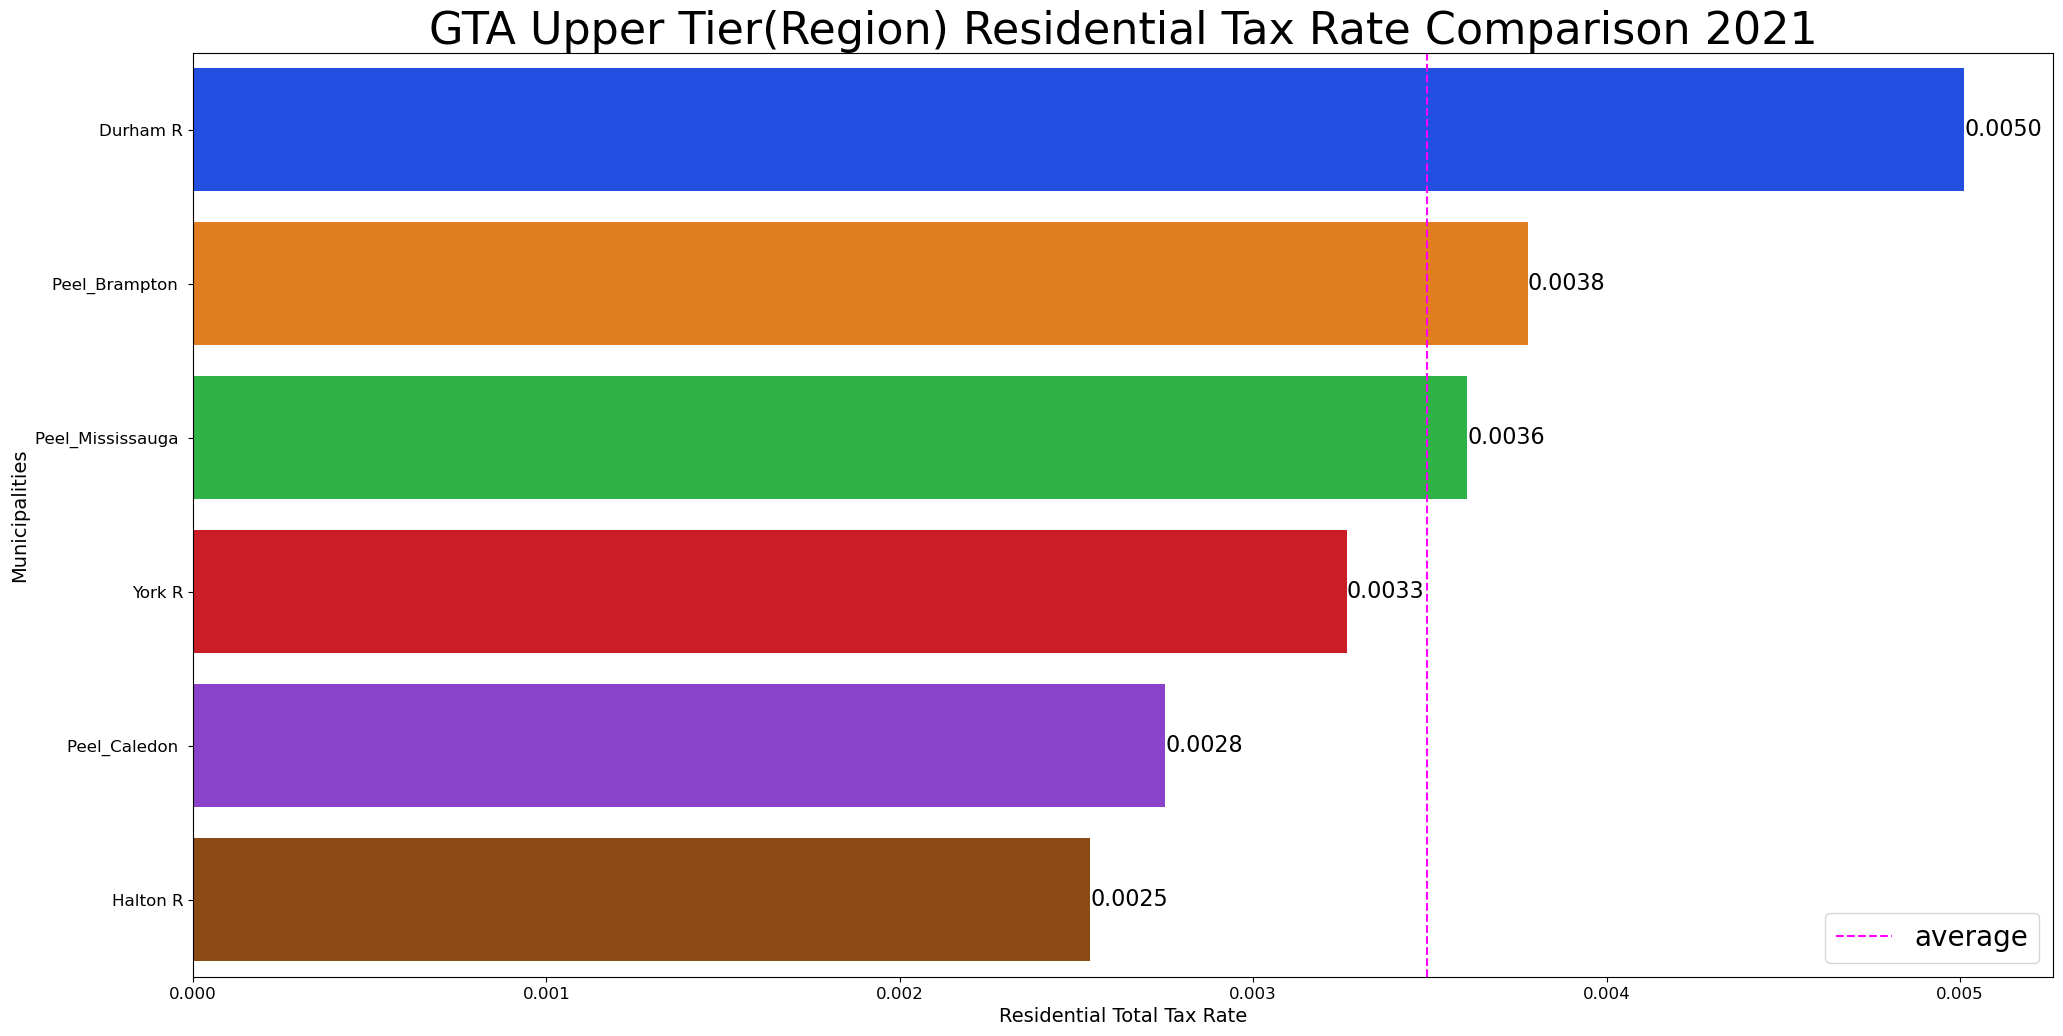

In [34]:
data=gta_ut_ptax[gta_ut_ptax['Property_Class'] == 'Residential'].sort_values(by='Total_TaxRate', ascending=False)

peel_parts = ['Mississauga part', 'Brampton part', 'Caledon part']

for part in peel_parts:
    data.loc[(data['Municipality'] == 'Peel R') & (data['Levy_Area'] == part), 'Municipality'] = 'Peel_'+ part[:-4]

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data, y='Municipality', x='Total_TaxRate', orient='h', palette='bright', dodge=False)
ax.set_xlabel('Residential Total Tax Rate', fontsize=14)
ax.set_ylabel('Municipalities', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_title('GTA Upper Tier(Region) Residential Tax Rate Comparison 2021', fontsize=32)
ax.bar_label(ax.containers[0], fmt='%.4f', fontsize=16)
plt.axvline(data['Total_TaxRate'].mean(), color='magenta', linestyle='dashed', label='average')
plt.legend(loc='lower right', prop={'size':20})
plt.show()

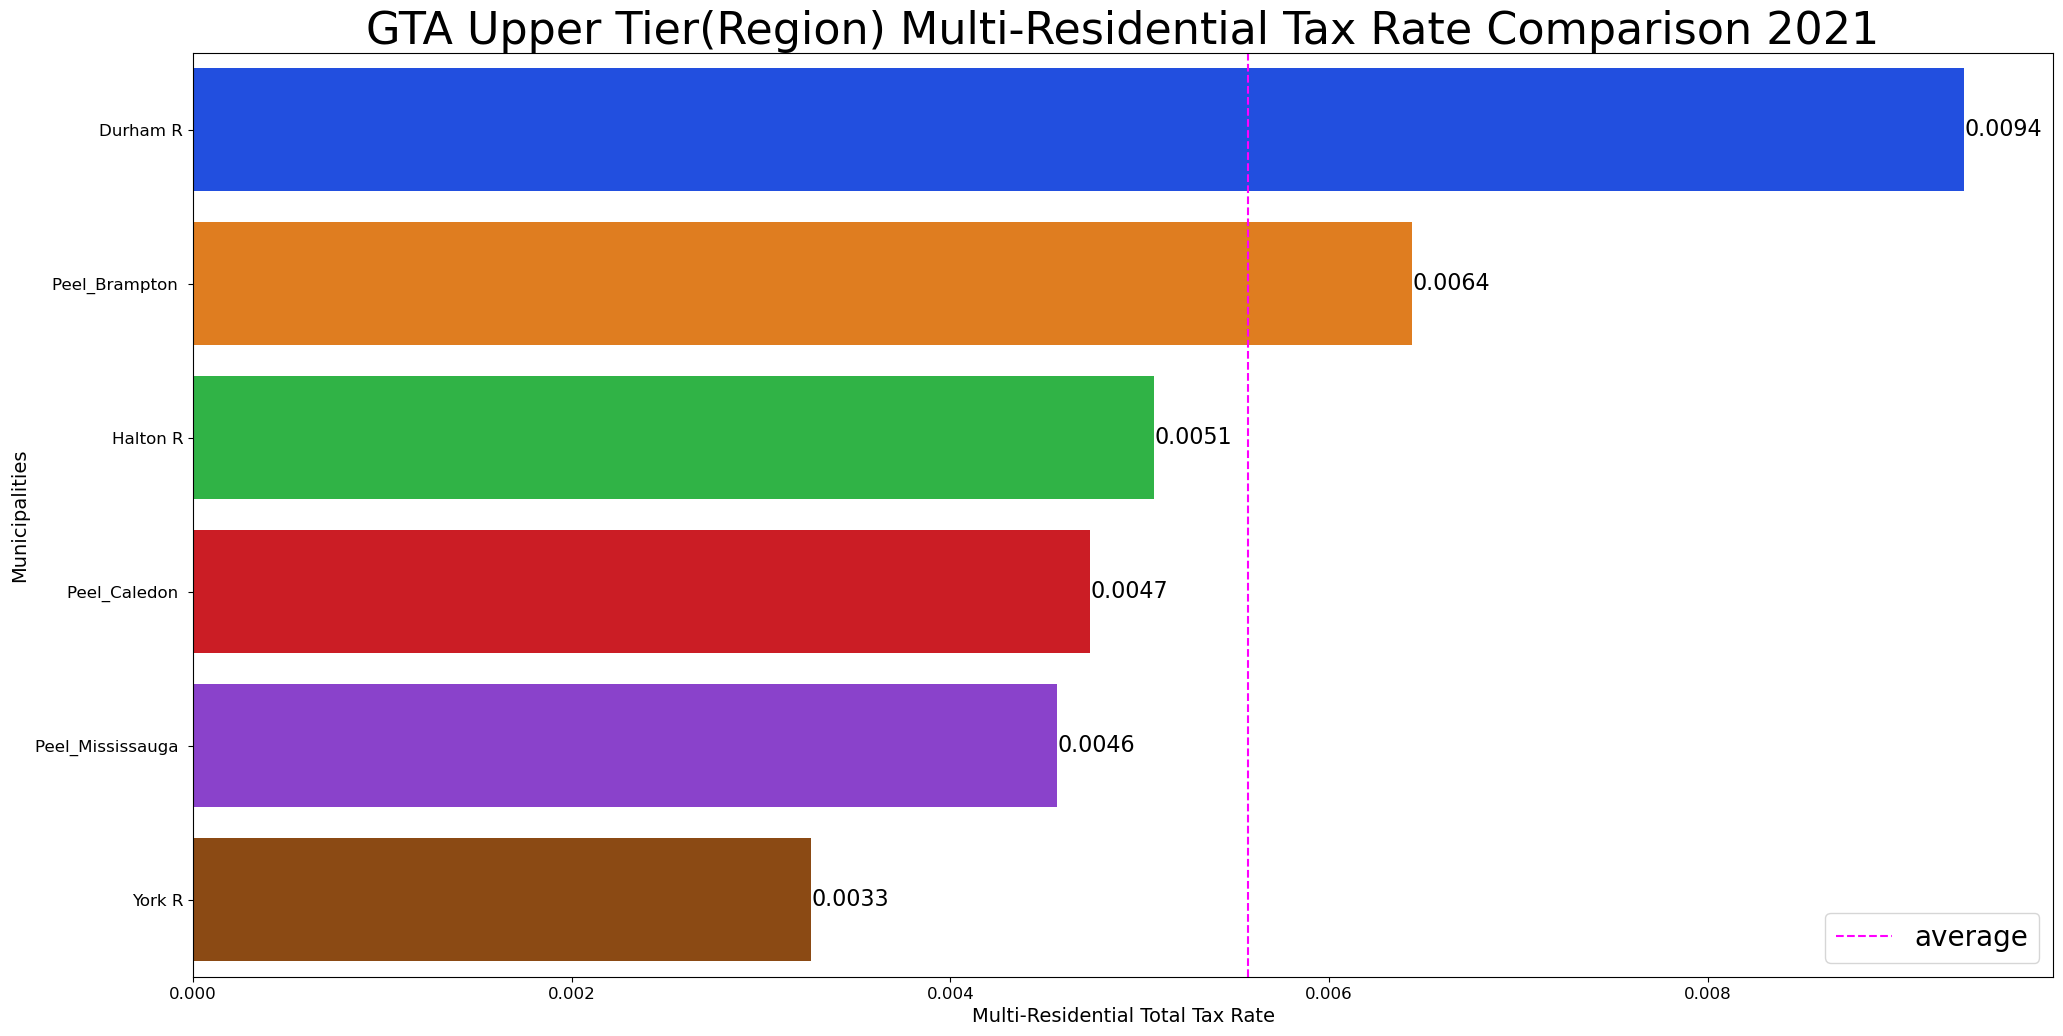

In [35]:
### Regions
gta_ut_ptax = gta_ptax_frame[gta_ptax_frame.Municipality.isin(upper_tier)]

data=gta_ut_ptax[gta_ut_ptax['Property_Class'] == 'Multi-Residential'].sort_values(by='Total_TaxRate', ascending=False)

peel_parts = ['Mississauga part', 'Brampton part', 'Caledon part']

for part in peel_parts:
    data.loc[(data['Municipality'] == 'Peel R') & (data['Levy_Area'] == part), 'Municipality'] = 'Peel_'+ part[:-4]

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data, y='Municipality', x='Total_TaxRate', orient='h', palette='bright', dodge=False)
ax.set_xlabel('Multi-Residential Total Tax Rate', fontsize=14)
ax.set_ylabel('Municipalities', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_title('GTA Upper Tier(Region) Multi-Residential Tax Rate Comparison 2021', fontsize=32)
ax.bar_label(ax.containers[0], fmt='%.4f', fontsize=16)
plt.axvline(data['Total_TaxRate'].mean(), color='magenta', linestyle='dashed', label='average')
plt.legend(loc='lower right', prop={'size':20})
plt.show()

Again Peel Region is unique is so far that each municipality (Mississauga, Brampton and Caledon) have their own specific upper tier tax rate.

While Peel Region's upper tier rate for Mississauga(0.0046) and Caledon(0.0047) are very similar, the upper tier rate for Brampton is 0.006.  This seems like a fairly large difference.  This points to something else quite interesting - the total  Current Value Assessment for Multiresidential(fully occuppied) is by far the smallest of any of the three municipalities.

In [36]:
data

,Year,Municipality,Tier,Levy_Area,RTC/RTQ,TaxBand,Property_Class,Tax_Rate_Description,Tax_Ratio,CVA_Assessment,Phase_In_Taxable_Assessment,LowerSingleTier_Rate,UpperTier_Rate,Education_Rate,Total_TaxRate,LowerSingleTierTaxes,UpperTierTaxes,EducationTaxes,TotalTax
1534,2021,Durham R,UT,Durham R,MT,0,Multi-Residential,Full Occupied,1.866500,2.784581e+09,2.784581e+09,NaN,0.009356,NaN,0.009356,0,26053794,0,26053794
5169,2021,Peel_Brampton,UT,Brampton part,MT,0,Multi-Residential,Full Occupied,1.705000,1.772868e+09,1.772868e+09,NaN,0.006439,NaN,0.006439,0,11415144,0,11415144
2545,2021,Halton R,UT,Halton R,MT,0,Multi-Residential,Full Occupied,2.000000,3.174215e+09,3.174215e+09,NaN,0.005077,NaN,0.005077,0,16117044,0,16117044
5204,2021,Peel_Caledon,UT,Caledon part,MT,0,Multi-Residential,Full Occupied,1.722344,3.647780e+07,3.647780e+07,NaN,0.004740,NaN,0.004740,0,172895,0,172895
5232,2021,Peel_Mississauga,UT,Mississauga part,MT,0,Multi-Residential,Full Occupied,1.265604,6.961733e+09,6.961733e+09,NaN,0.004564,NaN,0.004564,0,31772442,0,31772442
7832,2021,York R,UT,York R,MT,0,Multi-Residential,Full Occupied,1.000000,3.132845e+09,3.132845e+09,NaN,0.003264,NaN,0.003264,0,10226389,0,10226389


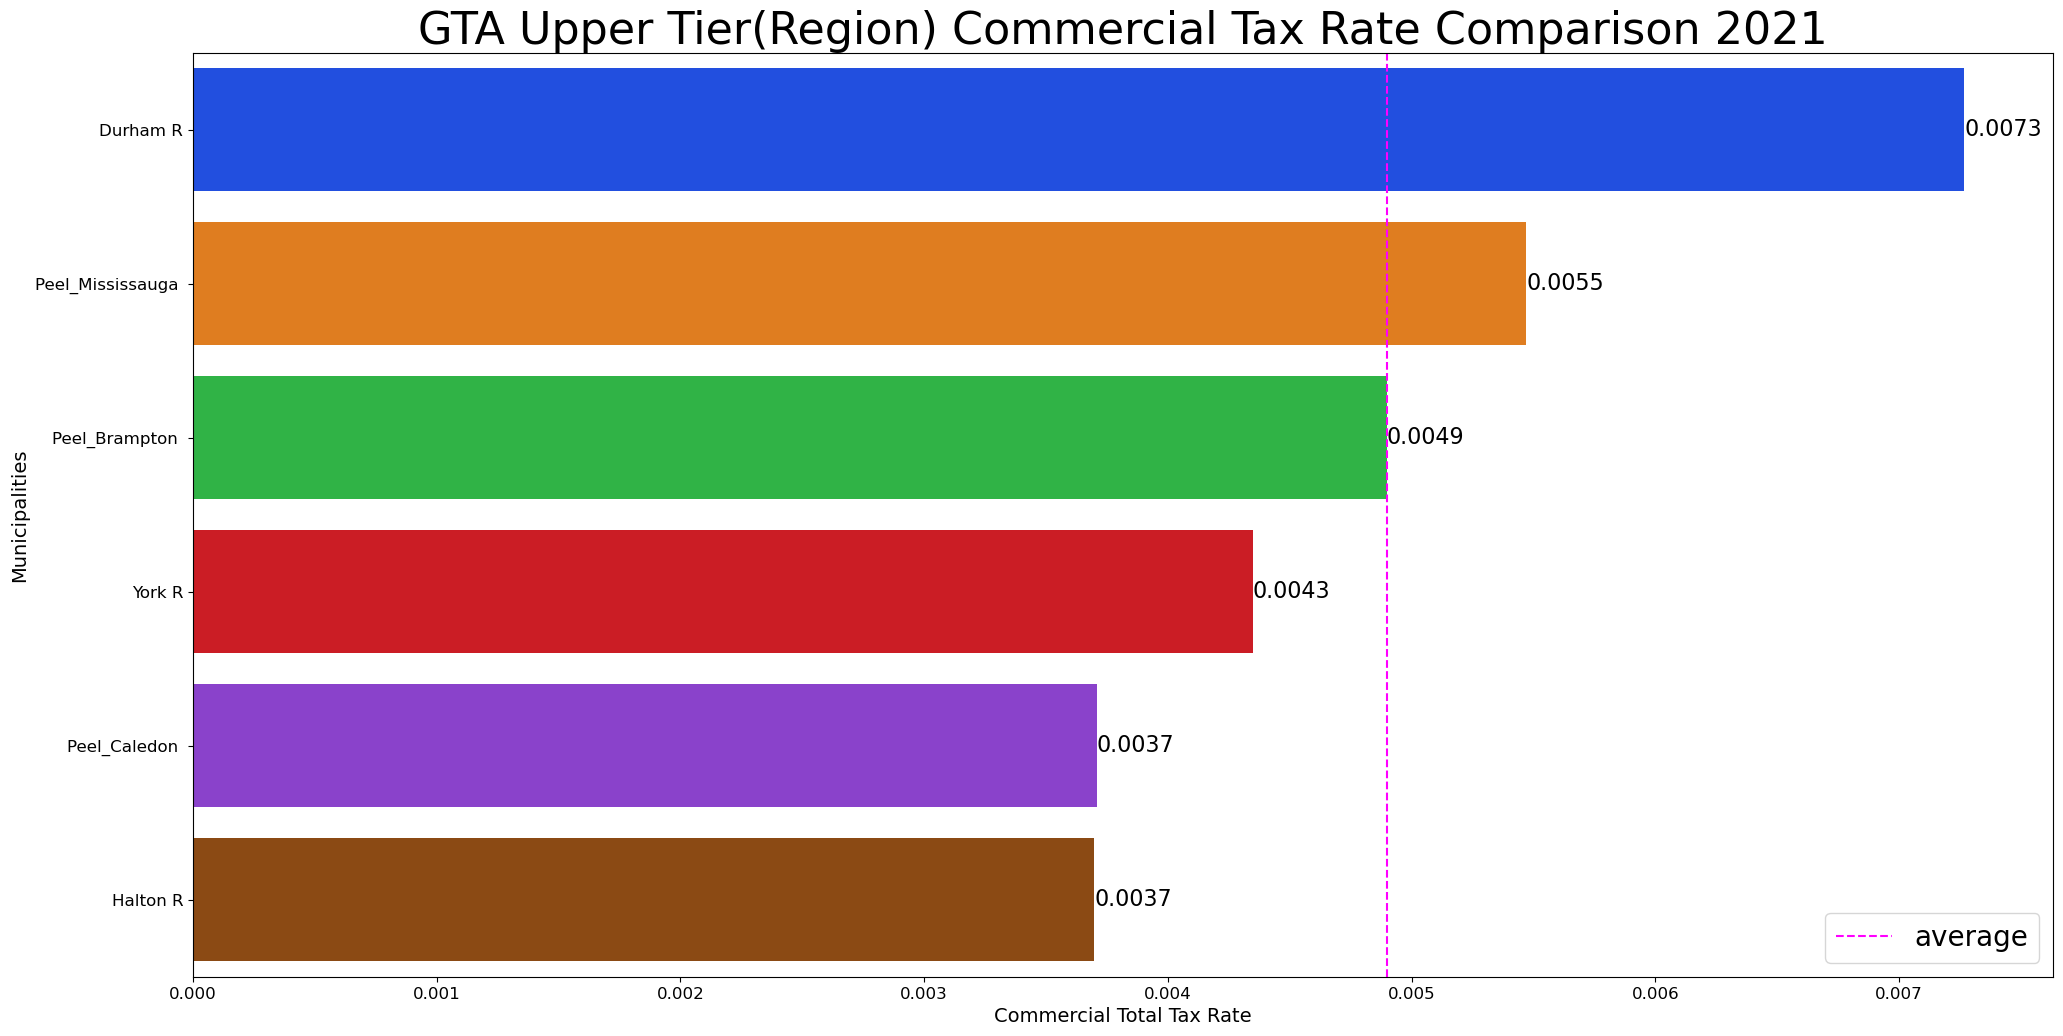

In [37]:
gta_ut_ptax = gta_ptax_frame[gta_ptax_frame.Municipality.isin(upper_tier)]

data=gta_ut_ptax[gta_ut_ptax['Property_Class'] == 'Commercial'].sort_values(by='Total_TaxRate', ascending=False)

peel_parts = ['Mississauga part', 'Brampton part', 'Caledon part']

for part in peel_parts:
    data.loc[(data['Municipality'] == 'Peel R') & (data['Levy_Area'] == part), 'Municipality'] = 'Peel_'+ part[:-4]

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data, y='Municipality', x='Total_TaxRate', orient='h', palette='bright', dodge=False)
ax.set_xlabel('Commercial Total Tax Rate', fontsize=14)
ax.set_ylabel('Municipalities', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_title('GTA Upper Tier(Region) Commercial Tax Rate Comparison 2021', fontsize=32)
ax.bar_label(ax.containers[0], fmt='%.4f', fontsize=16)
plt.axvline(data['Total_TaxRate'].mean(), color='magenta', linestyle='dashed', label='average')
plt.legend(loc='lower right', prop={'size':20})
plt.show()

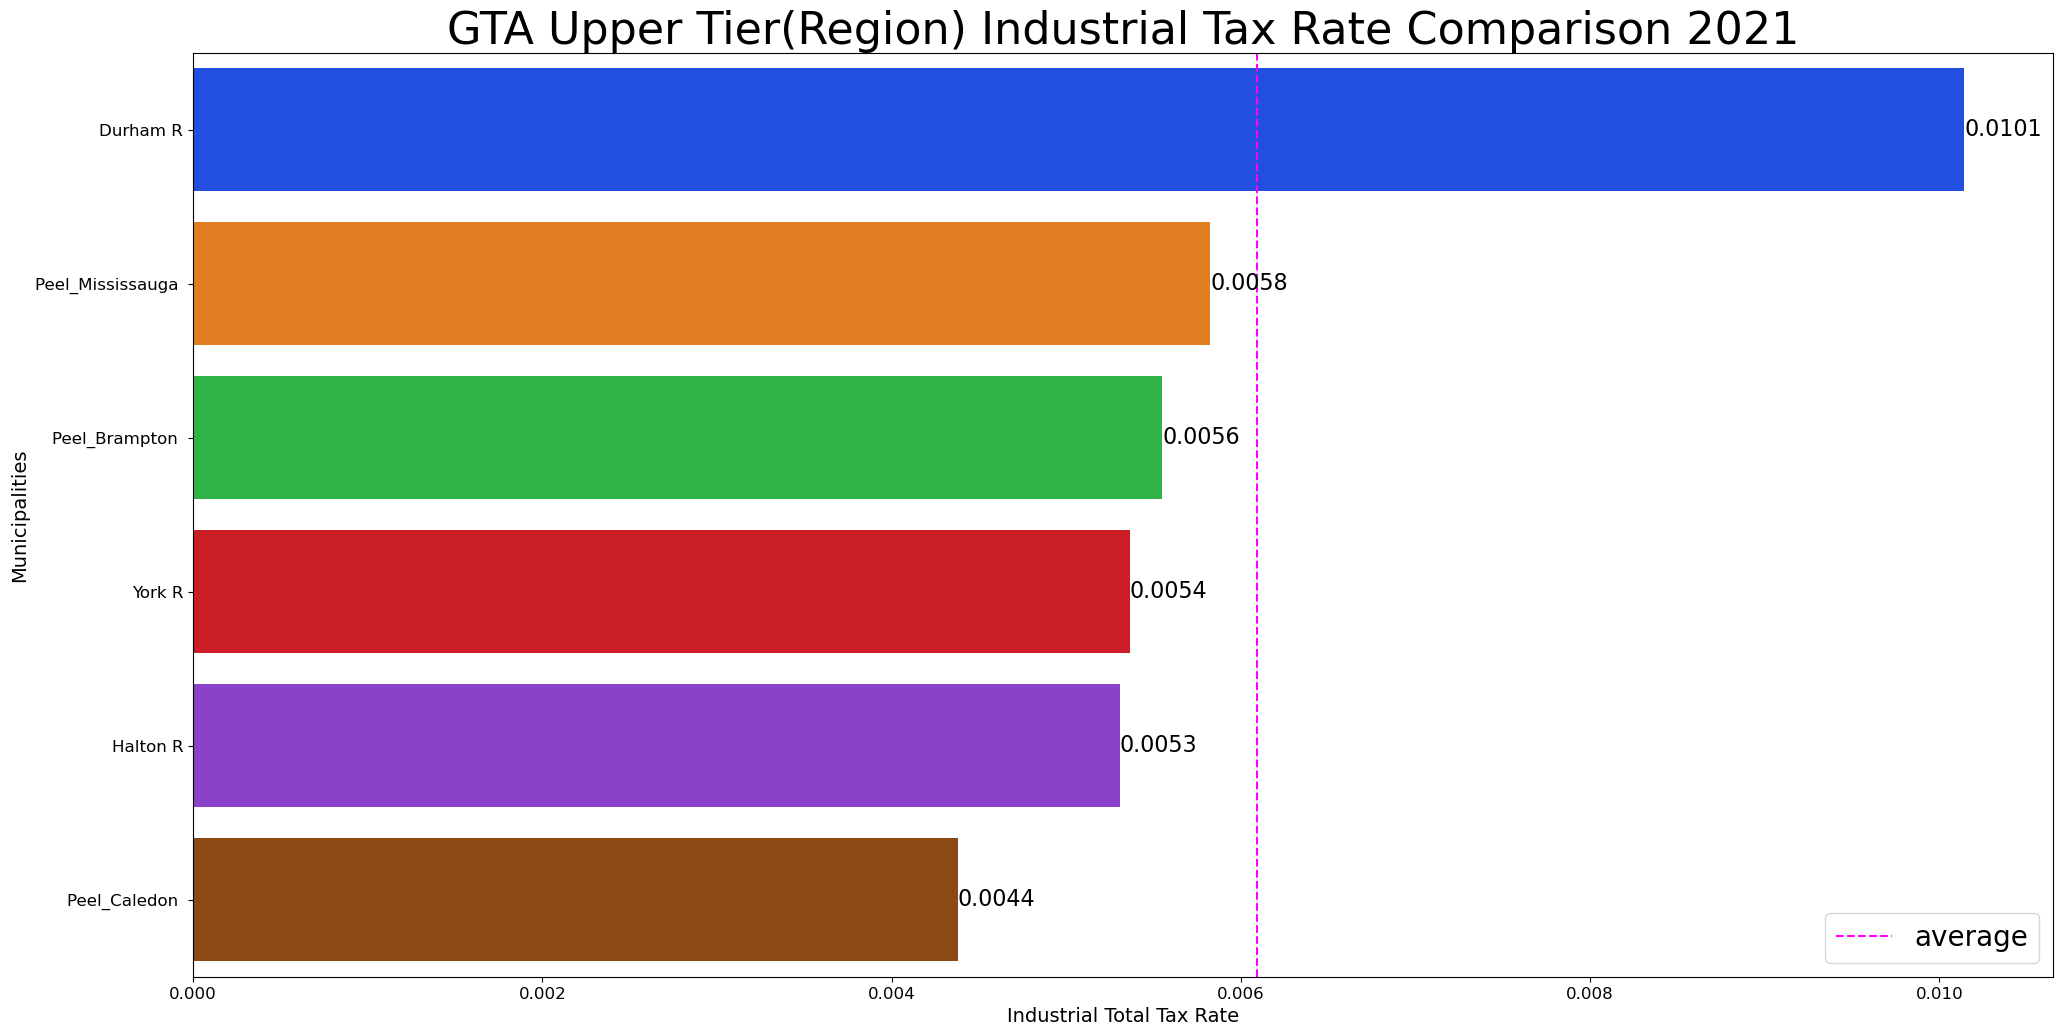

In [38]:
gta_ut_ptax = gta_ptax_frame[gta_ptax_frame.Municipality.isin(upper_tier)]

data=gta_ut_ptax[gta_ut_ptax['Property_Class'] == 'Industrial'].sort_values(by='Total_TaxRate', ascending=False)

peel_parts = ['Mississauga part', 'Brampton part', 'Caledon part']

for part in peel_parts:
    data.loc[(data['Municipality'] == 'Peel R') & (data['Levy_Area'] == part), 'Municipality'] = 'Peel_'+ part[:-4]

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data, y='Municipality', x='Total_TaxRate', orient='h', palette='bright', dodge=False)
ax.set_xlabel('Industrial Total Tax Rate', fontsize=14)
ax.set_ylabel('Municipalities', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_title('GTA Upper Tier(Region) Industrial Tax Rate Comparison 2021', fontsize=32)
ax.bar_label(ax.containers[0], fmt='%.4f', fontsize=16)
plt.axvline(data['Total_TaxRate'].mean(), color='magenta', linestyle='dashed', label='average')
plt.legend(loc='lower right', prop={'size':20})
plt.show()

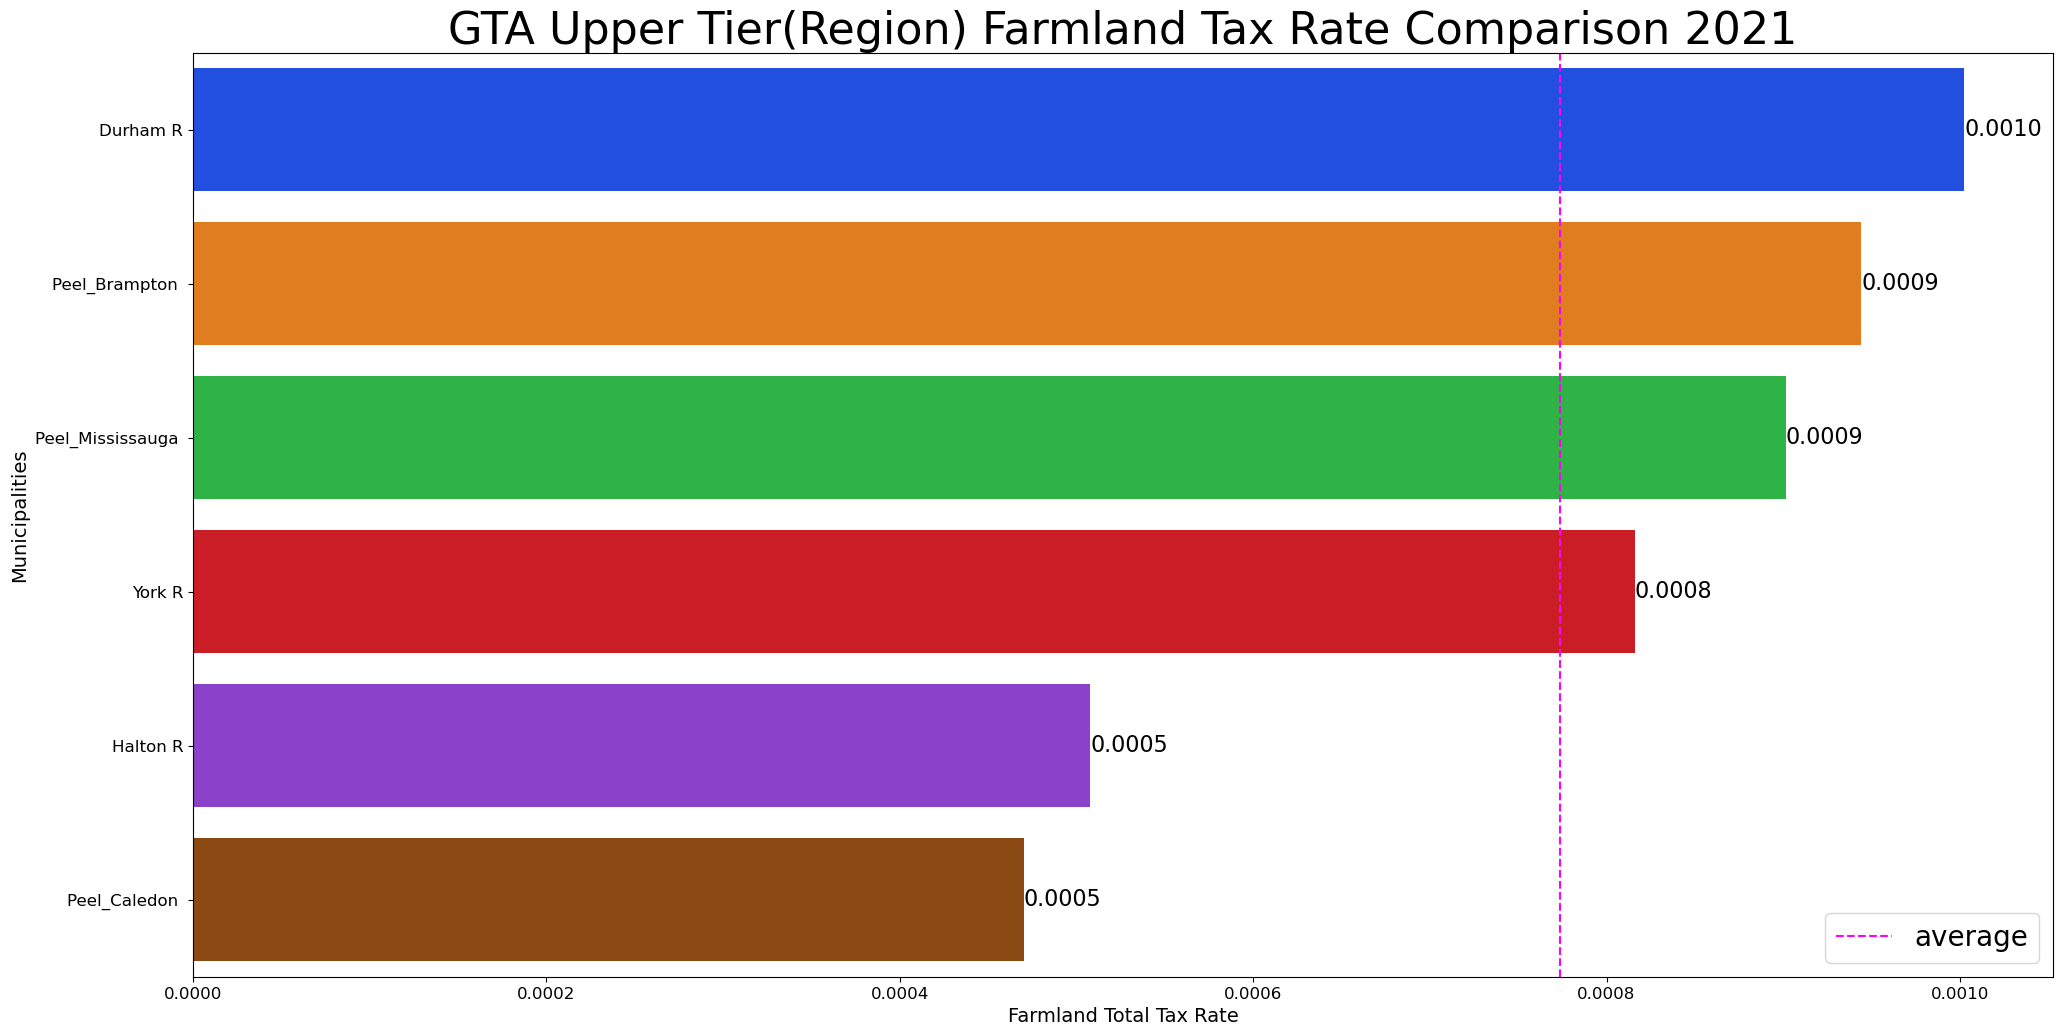

In [39]:
gta_ut_ptax = gta_ptax_frame[gta_ptax_frame.Municipality.isin(upper_tier)]

data=gta_ut_ptax[gta_ut_ptax['Property_Class'] == 'Farmland'].sort_values(by='Total_TaxRate', ascending=False)

peel_parts = ['Mississauga part', 'Brampton part', 'Caledon part']

for part in peel_parts:
    data.loc[(data['Municipality'] == 'Peel R') & (data['Levy_Area'] == part), 'Municipality'] = 'Peel_'+ part[:-4]

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data, y='Municipality', x='Total_TaxRate', orient='h', palette='bright', dodge=False)
ax.set_xlabel('Farmland Total Tax Rate', fontsize=14)
ax.set_ylabel('Municipalities', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_title('GTA Upper Tier(Region) Farmland Tax Rate Comparison 2021', fontsize=32)
ax.bar_label(ax.containers[0], fmt='%.4f', fontsize=16)
plt.axvline(data['Total_TaxRate'].mean(), color='magenta', linestyle='dashed', label='average')
plt.legend(loc='lower right', prop={'size':20})
plt.show()

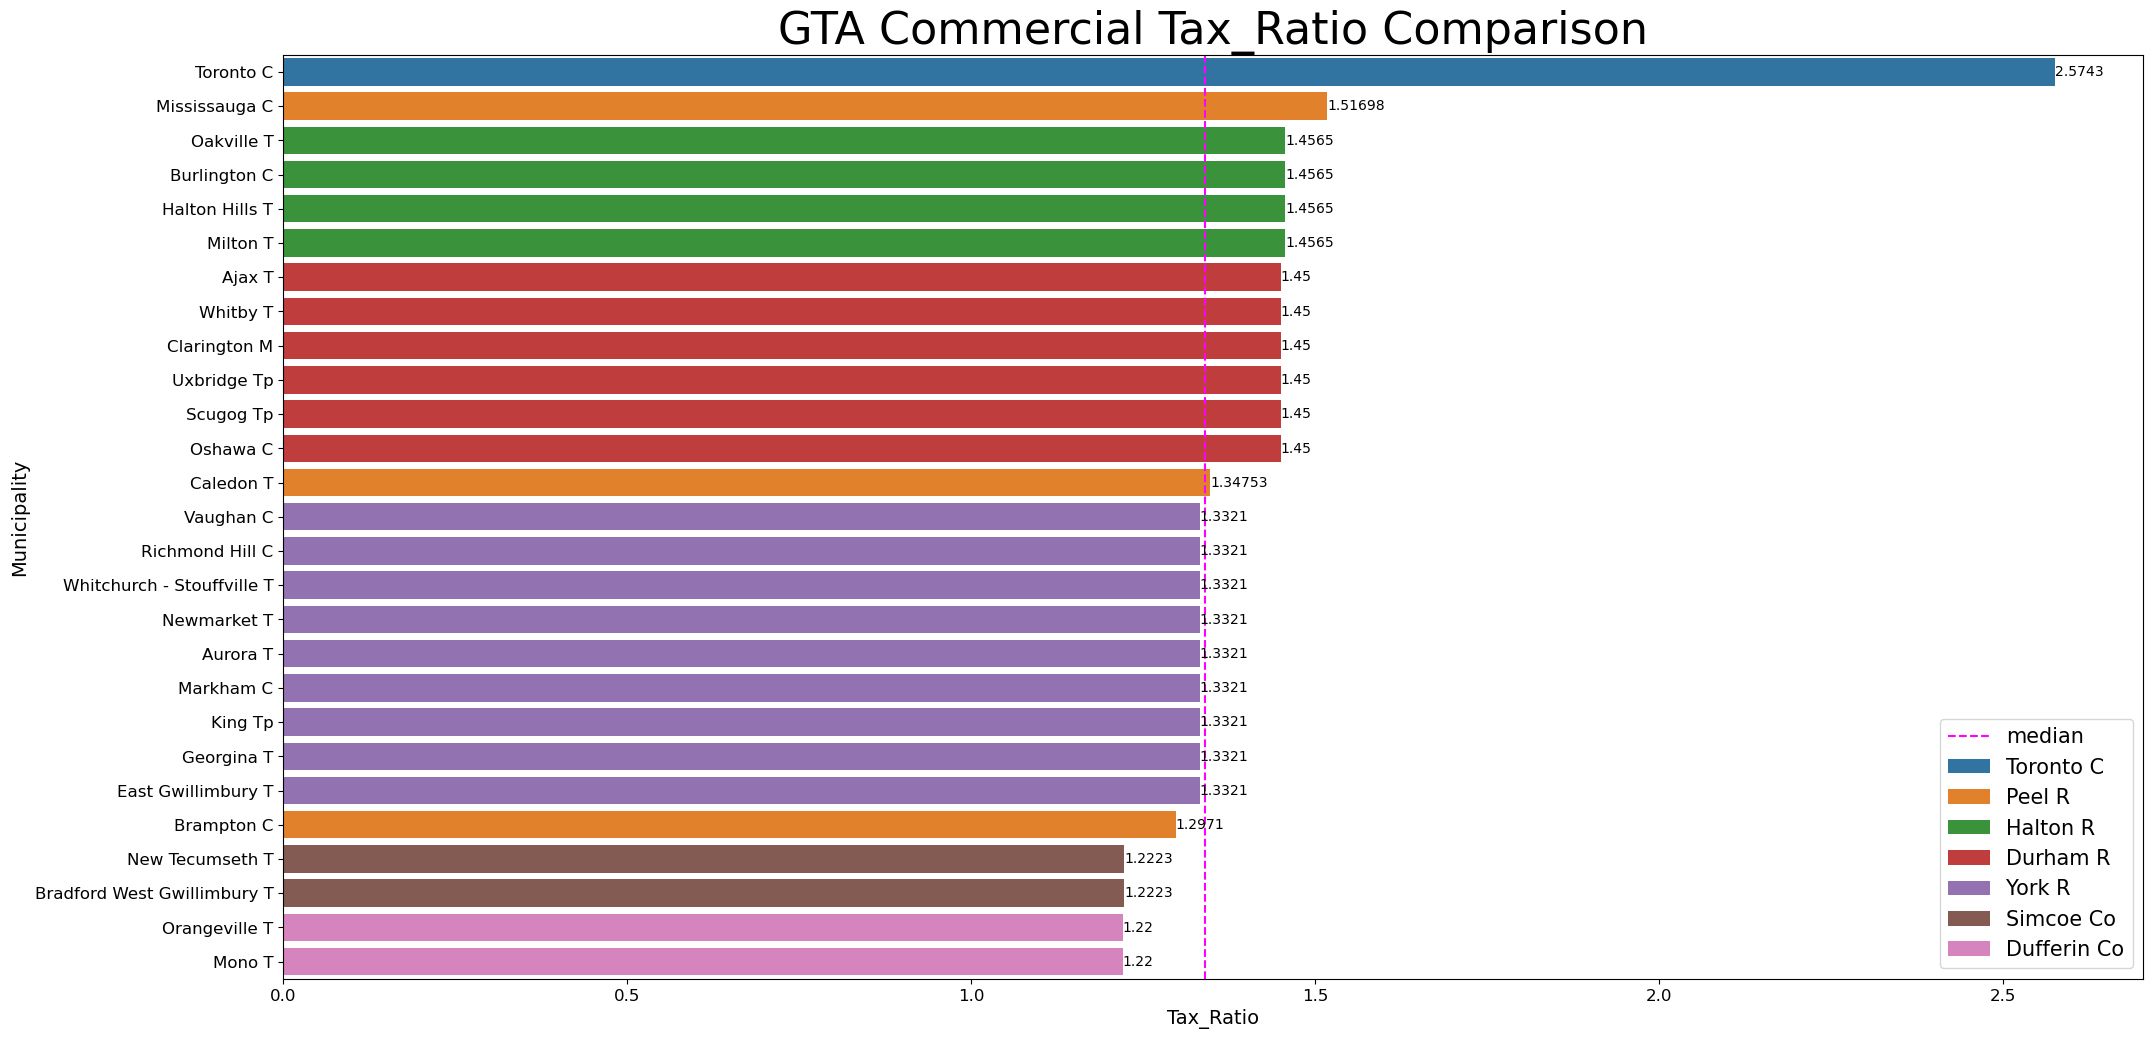

In [40]:
data = gta_sL_ptax[['Municipality', 'Property_Class', 'Tax_Ratio', 'Region']][gta_sL_ptax['Property_Class'].isin(['Commercial'])]

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data.sort_values(by='Tax_Ratio', ascending=False), y='Municipality', x='Tax_Ratio', hue='Region', orient='h', dodge=False)
ax.set_xlabel('Tax_Ratio', fontsize=14)
ax.set_ylabel('Municipality', fontsize=14)
ax.set_title('GTA Commercial Tax_Ratio Comparison', fontsize=32)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
for container in ax.containers:
    ax.bar_label(container)
plt.axvline(data['Tax_Ratio'].median(), color='magenta', linestyle='dashed', label='median')
plt.legend(loc='lower right', prop={'size':15})
plt.show()

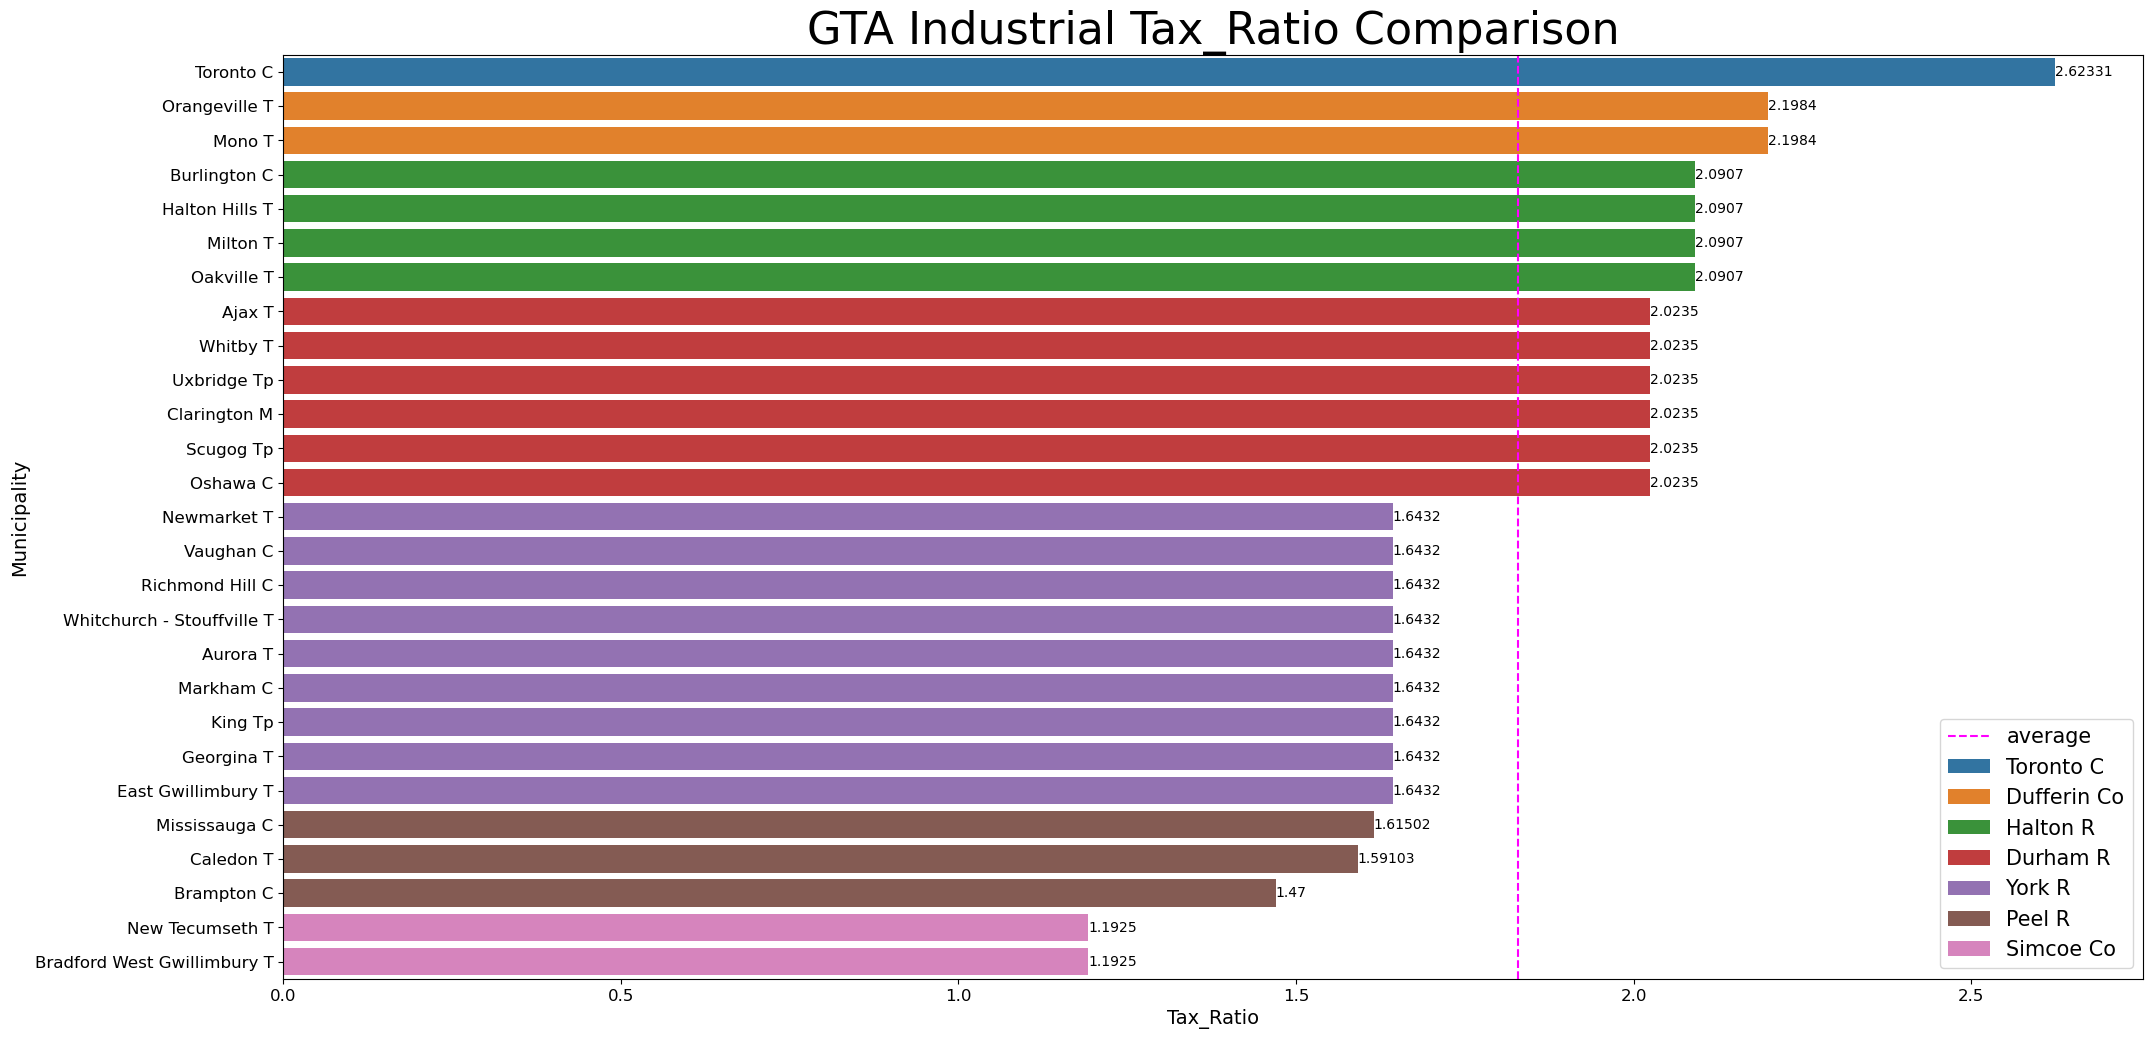

In [41]:
data = gta_sL_ptax[['Municipality', 'Property_Class', 'Tax_Ratio', 'Region']][gta_sL_ptax['Property_Class'].isin(['Industrial'])]

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data.sort_values(by='Tax_Ratio', ascending=False), y='Municipality', x='Tax_Ratio', hue='Region', orient='h', dodge=False)
ax.set_xlabel('Tax_Ratio', fontsize=14)
ax.set_ylabel('Municipality', fontsize=14)
ax.set_title('GTA Industrial Tax_Ratio Comparison', fontsize=32)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
for container in ax.containers:
    ax.bar_label(container)
plt.axvline(data['Tax_Ratio'].mean(), color='magenta', linestyle='dashed', label='average')
plt.legend(loc='lower right', prop={'size':15})
plt.show()

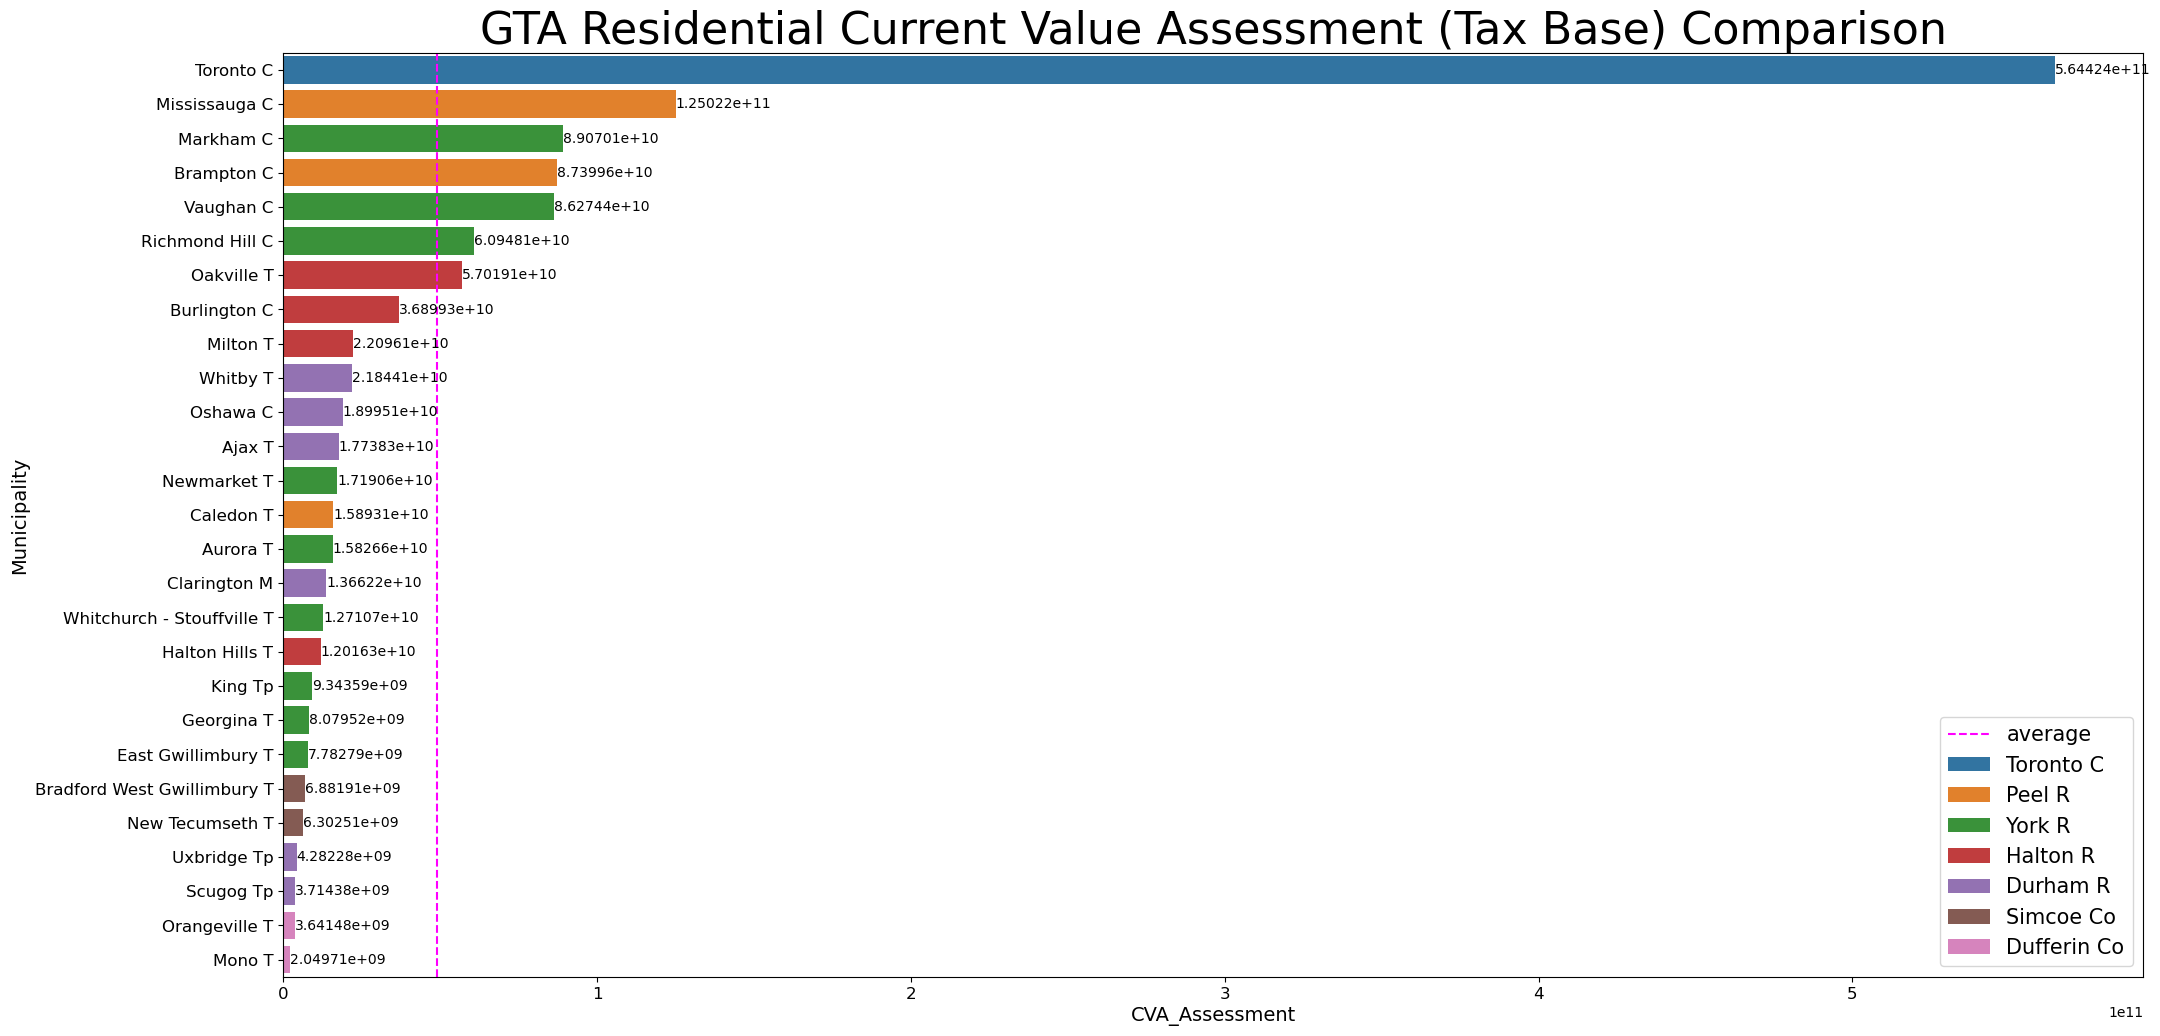

In [42]:
data = gta_sL_ptax[['Municipality', 'Property_Class', 'CVA_Assessment', 'Region']][gta_sL_ptax['Property_Class'].isin(['Residential'])]

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data.sort_values(by='CVA_Assessment', ascending=False), y='Municipality', x='CVA_Assessment', hue='Region', orient='h', dodge=False)
ax.set_xlabel('CVA_Assessment', fontsize=14)
ax.set_ylabel('Municipality', fontsize=14)
ax.set_title('GTA Residential Current Value Assessment (Tax Base) Comparison', fontsize=32)
 
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
for container in ax.containers:
    ax.bar_label(container)
plt.axvline(data['CVA_Assessment'].mean(), color='magenta', linestyle='dashed', label='average')
plt.legend(loc='lower right', prop={'size':15})
plt.show()

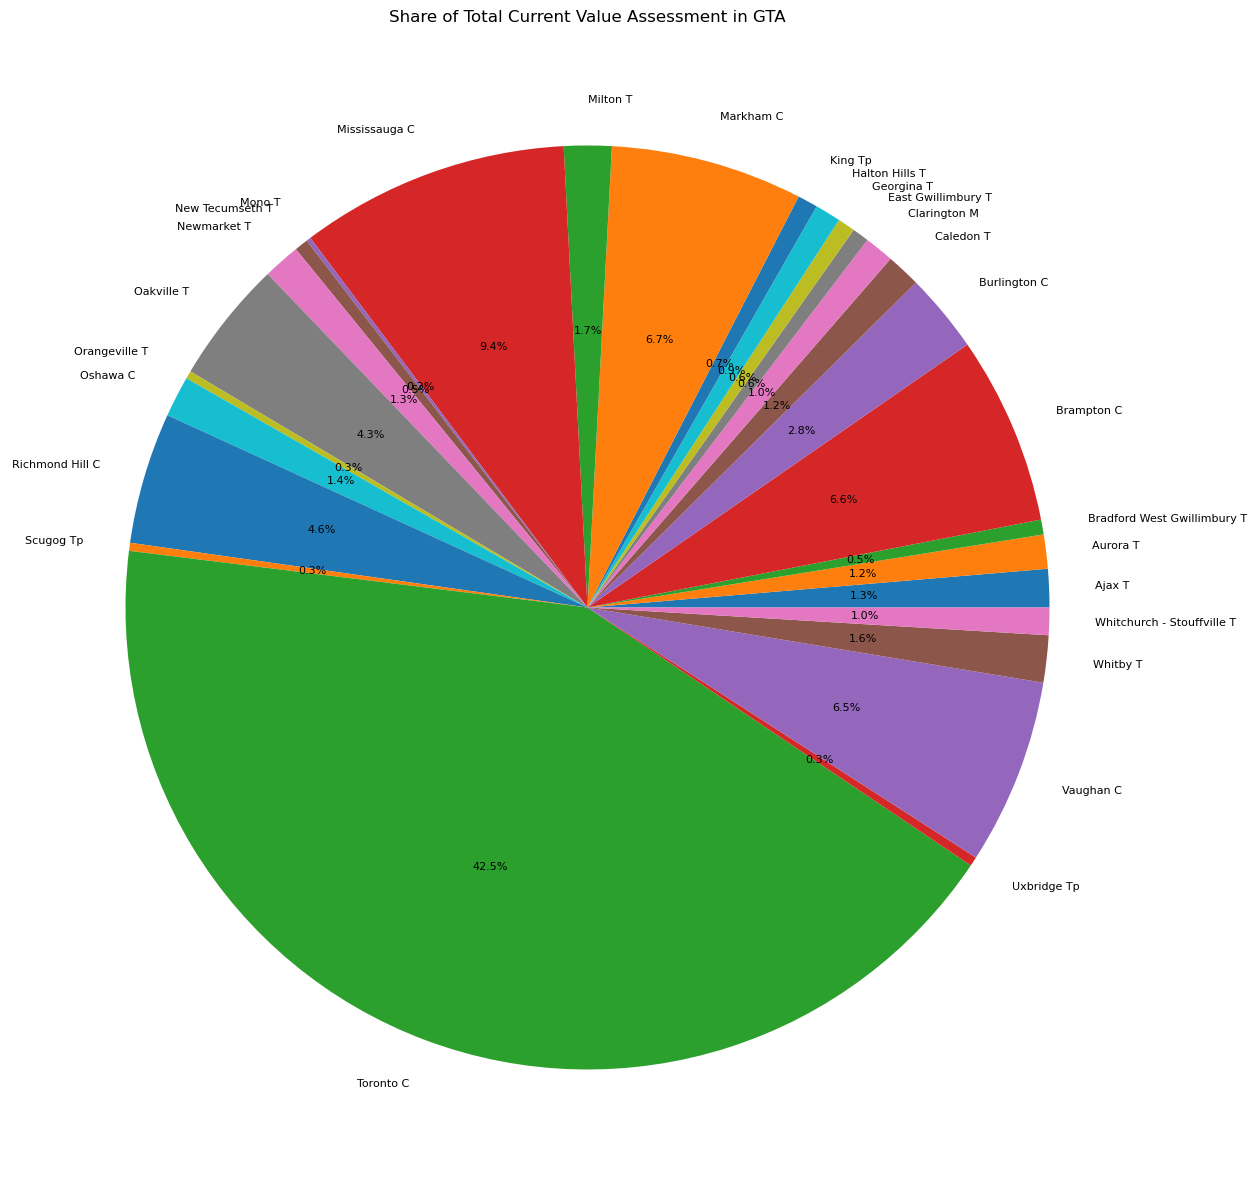

In [43]:
labels = gta_sL_ptax[gta_sL_ptax['Property_Class'] == 'Residential']['Municipality']
sizes=gta_sL_ptax[gta_sL_ptax['Property_Class'] == 'Residential']['CVA_Assessment']
fig, ax = plt.subplots(figsize=(24,15))
ax.pie(sizes, labels=labels, textprops={'fontsize': 8}, autopct='%1.1f%%')
ax.set_title('Share of Total Current Value Assessment in GTA')
plt.show()

In [44]:
gta_sL_ptax.head()

,Year,Municipality,Tier,Levy_Area,RTC/RTQ,TaxBand,Property_Class,Tax_Rate_Description,Tax_Ratio,CVA_Assessment,Phase_In_Taxable_Assessment,LowerSingleTier_Rate,UpperTier_Rate,Education_Rate,Total_TaxRate,LowerSingleTierTaxes,UpperTierTaxes,EducationTaxes,TotalTax,Region
55,2021,Ajax T,LT,Ajax T,RT,0,Residential,Full Occupied,1.0000,1.773831e+10,1.773831e+10,0.003414,0.005013,0.001530,0.009957,60558780,88919151,27139620,176617551,Durham R
56,2021,Ajax T,LT,Ajax T,MT,0,Multi-Residential,Full Occupied,1.8665,5.028436e+08,5.028436e+08,0.006372,0.009356,0.001530,0.017259,3204245,4704831,769351,8678427,Durham R
57,2021,Ajax T,LT,Ajax T,FT,0,Farmland,Full Occupied,0.2000,2.776680e+07,2.776680e+07,0.000683,0.001003,0.000382,0.002068,18959,27838,10621,57418,Durham R
58,2021,Ajax T,LT,Ajax T,CT,0,Commercial,Full Occupied,1.4500,9.720312e+08,9.720312e+08,0.004950,0.007269,0.008800,0.021019,4811856,7065306,8553874,20431036,Durham R
66,2021,Ajax T,LT,Ajax T,IT,0,Industrial,Full Occupied,2.0235,1.330657e+08,1.330657e+08,0.006908,0.010143,0.008800,0.025852,919251,1349747,1170978,3439976,Durham R


In [45]:
pclasses = ['Residential', 'Commercial', 'Industrial', 'Farmland']

In [46]:
combine_frame = ptax_frame[(ptax_frame['Property_Class'].isin(pclasses)) & (ptax_frame['Tax_Rate_Description'] == 'Full Occupied')].copy()

In [47]:
combine_frame = combine_frame[['Year', 'Municipality', 'Property_Class', 'Total_TaxRate']]

In [48]:
combine_frame.loc[:, 'Province'] = 'ON'

In [49]:
combine_frame.rename(columns={'Property_Class':'PropertyClass', 'Total_TaxRate':'Rate'}, inplace=True)

In [50]:
combine_frame.reset_index(inplace=True,drop=True)

In [51]:
combine_frame.tail(2)

,Year,Municipality,PropertyClass,Rate,Province
1620,2021,Zorra Tp,Commercial,0.025729,ON
1621,2021,Zorra Tp,Industrial,0.032212,ON


In [52]:
combine_frame.shape

(1622, 5)

In [53]:
os.getcwd()

'd:\\david\\MyStuff\\Docs\\VSC_Projects\\propertTax_comps'

In [54]:
os.chdir('data')

In [55]:
files = os.listdir()
if 'ON_2021.csv' in files:
    pass
else:
    combine_frame.to_csv('ON_2021.csv', index=False)

In [56]:
if 'ON_2021.csv' in files:
    print('OK then')